# The implementation of thesis project with keras/tensorflow

# Introduction

In this Python notesbook, we choose the following as baselines and evaluate their performances:
- Supervised learning with simple convolutional network (training from scratch)
- Supervised learning with MLP (training from scratch)
- Supervised learning with ResNet50
- Supervised learning with VGG16
- Supervised learning with MobileNet

We then evaluate our self-supervised contrastive model, which uses InfoNCE, known as NT-Xent (Normalized Temperature-scaled Cross Entropy Loss) in SimCLR and used in other works like MoCo.

The goal of our texture classification model is to train an embedding space constrained by contrastive loss, our model consists of two image augmentation transformers, base encoder, a projection head, and a pure linear regressor with cross-entropy loss as the customised accuracy metric.

We evaluate our proposed model with:
- Contrastive learning with simple convolutional network as encoder (training from scratch)
- Contrastive learning with VGG16 as encoder
- Contrastive learning with Vision Transformer (ViT) as encoder (training from scratch)

# Importing libraries

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

import numpy as np
import pandas as pd
import os
import sys
import random

import matplotlib.pyplot as plt

# enable GPU on macOS
#import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#os.environ["RUNFILES_DIR"] = "/usr/local/anaconda3/share/plaidml"
#os.environ["PLAIDML_NATIVE_PATH"] = "/usr/local/anaconda3/lib/libplaidml.dylib"
#import keras

# Setting local library path

Our modules lie in the directory *lib*, we add the path to the library searching path:

In [2]:
import numpy as np
import pandas as pd
import os
import sys 

#libpath = "lib"
#sys.path.append(libpath)

# Configurations

In [3]:
#image_size = (128, 128)
image_size = (64, 64) #faster for running on laptop

#dataset_root_orig = ""

n_image_channels = 3

#input image shape
image_shape = (*image_size, n_image_channels) 


# sample batch size
batch_size = 128  
#batch_size = 64


# how many epochs
n_epochs = 20

temperature = 0.2
#temperature = 0.5



#relatively slight augmentation
imgaug_params = { 
                  "min_area": 0.75, 
                  "brightness": 0.3, 
                  "jitter": 0.1
                }

#relatively strong augmentation
#imgaug_params = {  
#                  "min_area": 0.25, 
#                  "brightness": 0.6, 
#                  "jitter": 0.2
#                }

# Bootstrapping the dataset

## Image augmentation model for dataset bootstrapping

In [345]:
from tensorflow.keras.layers.experimental import preprocessing as keras_preprocessing_layers


class CustomisedBootstrapImageAugmenter(keras.layers.Layer):
    def __init__(self,
                 target_size = (128, 128),
                 seed = 1121,
                 name = 'boostrap_imgaug_layer',
                 **kwargs):

        self.target_size = target_size
        self.seed = seed

        self.model = keras.Sequential([
              #keras_preprocessing_layers.Rescaling(1.0 / 255),
              #keras_preprocessing_layers.Normalization(),
              keras_preprocessing_layers.RandomFlip(
                                        "horizontal", 
                                        seed = self.seed
                                    ),
              keras_preprocessing_layers.RandomZoom(
                                        height_factor=0.3, 
                                        width_factor=0.3,
                                        seed = self.seed
                                    ),
              keras_preprocessing_layers.RandomRotation(
                                        0.5, 
                                        seed = self.seed
                                    ),
              keras_preprocessing_layers.RandomCrop(
                                        *self.target_size,
                                        seed = self.seed
                                    )

             ],
             name = "bootstrap_imgaug_model")

        super(CustomisedBootstrapImageAugmenter, self).__init__(name = name, **kwargs)

    def get_config(self):
        config = super().get_config()
        
        config['target_size'] = self.target_size
        config['seed'] = self.seed
        config['model'] = self.model

        return config

    def call(self, images, training = True):
        if training:
            images = self.model(images)
        
        return images
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)

# The facilities of operating the original dataset

In [19]:
import numpy as np
import pandas as pd
import os
import sys 


TEXTURE_DS_IMAGE_SIZE = (512, 512)

def get_texture_subdirs():
    dataset_root = "datasets_orig"

    subdirs = [d.path for d in os.scandir(dataset_root) 
                        if d.is_dir(follow_symlinks = False) and 
                            not d.name.startswith(".") and 
                            not d.name.endswith("_npy")]

    subdirs = [s.rsplit(r"/", 1)[1] for s in subdirs]

    return subdirs

In [20]:
get_texture_subdirs()

['Normalised_Brodatz_Texture',
 'Multiband_Brodatz_Texture',
 'Colored_Brodatz_Texture']

In [23]:
def load_texture_dataset_xy(*, image_size = TEXTURE_DS_IMAGE_SIZE, dataset_name):
    
    assert dataset_name  is not None, "The dataset_name must be specified."

    #dataset_path = "datasets_orig" + os.path.sep + "Multiband_Brodatz_Texture"
    dataset_path = "datasets_orig" + os.path.sep + dataset_name

    assert os.path.exists(dataset_path), f"{dataset_path} does not exist."

    
    print()
    print(f"Loading dataset from path: {dataset_path} ...")
    print("image size: ", image_size)
    
    X = [] 
    y = []
    

    # Get the subdirs for given dataset path

    files = []
    
    suffixes = (".tif", ".gif", ".png", ".jpg")
    
    imgfiles = [d.path for d in os.scandir(dataset_path) 
                    if d.is_file(follow_symlinks = False) and 
                        not d.name.startswith(".") and
                        d.name.lower().endswith(suffixes) ]
    
    #print(imgfiles)
    
    for p in sorted(imgfiles):
        #print(p)

        
        # Loading images and pre-processing images
        img = keras.preprocessing.image.load_img( path = p,
                        grayscale = False, 
                        color_mode='rgb', 
                        target_size = image_size)
        
        # Converting images into numpy arraries.
        img = keras.preprocessing.image.img_to_array(
                        img = img,
                        data_format = "channels_last",
                        dtype = np.double)
        
                        
        filename, file_extension = os.path.splitext(p)
        
        label = os.path.basename(filename)
        
        #print(label)

        X.append(img)
        y.append(label)
        
    print(f"Total {len(y)} images are loaded.")    
    #print()
    
    X = np.array(X)
    y = np.array(y)
    #X = X.astype('float32')
    
    return X, y 


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (128, 128)
Total 154 images are loaded.

num_of_samples:  154
shape:  (154, 128, 128, 3)


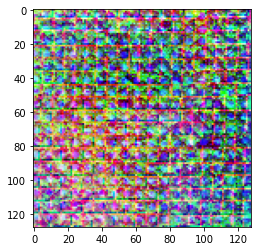

In [32]:
X, y = load_texture_dataset_xy(image_size = (128, 128), 
                               dataset_name = "Multiband_Brodatz_Texture")

print()
print("num_of_samples: ", len(y))
print("shape: ", X.shape)
    
plt.imshow(np.uint8(X[0]))
plt.show()

del X, y

In [25]:
def load_texture_dataset_as_dataframe(*, image_size = TEXTURE_DS_IMAGE_SIZE, dataset_name):

    X, y = load_texture_dataset_xy(image_size = image_size, dataset_name = dataset_name)
    
    data = {"X": list(X),
            "y": list(y)}
    
    df = pd.DataFrame(data) 
    
    return df


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (128, 128)
Total 154 images are loaded.

num_of_samples:  154


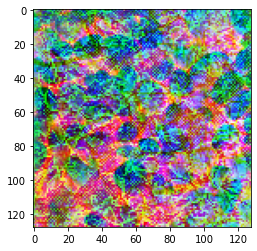

In [35]:
df = load_texture_dataset_as_dataframe(image_size = (128, 128), 
                               dataset_name = "Multiband_Brodatz_Texture")

print()
print("num_of_samples: ", len(df))
    
plt.imshow(np.uint8(df["X"][2]))
plt.show()

del df

In [31]:
def save_texture_dataset_as_numpy(*, image_size = TEXTURE_DS_IMAGE_SIZE, dataset_name, save_prefix):

    X, y = load_texture_dataset_xy(image_size = image_size, dataset_name = dataset_name)

    np.save(f"{save_prefix}_X.npy", X)
    np.save(f"{save_prefix}_y.npy", y)

## Splitting the orignal dataset for training and testing regarding pixels

In [6]:
import numpy as np
import pandas as pd
import os
import sys 

#libpath = os.path.dirname(os.path.realpath(__file__)) + os.path.sep + ".." + os.path.sep + "lib"
#libpath = os.path.dirname(os.path.realpath(__file__)) + os.path.sep + "."
#sys.path.append(libpath)

DS_DEFAULT_PIXEL_SPLIT_RATIO = 0.5

def split_dataset_by_pixel(X, y, split = DS_DEFAULT_PIXEL_SPLIT_RATIO):
    X_train = []
    y_train = []
    
    X_test = []
    y_test = []
    
    
    for Xi, yi in zip(X, y):
        Xi = np.array(Xi)
        #print(Xi.shape)
        #print(yi)
        
        height = Xi.shape[0]
        
        position = int(split * height)

        Xi_train = Xi[0:position, :, :]
        Xi_test = Xi[position:height, :, :]
        
        #print(Xi_train.shape)
        #print(Xi_test.shape)
        
        yi_train = yi
        yi_test = yi
        
        X_train.append(Xi_train)
        y_train.append(yi_train)
        
        X_test.append(Xi_test)
        y_test.append(yi_test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    print()
    print("Splitting dataset into training and testing datasets ...")
    print(f"size of training dataset : {len(y_train)}")
    print(f"size of testing dataset : {len(y_test)}")
    print(f"training dataset shape: {X_train.shape}")
    print(f"testing dataset shape: {X_test.shape}")
    #print()
    
    return X_train, y_train, X_test, y_test


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (128, 128)
Total 154 images are loaded.

Splitting dataset into training and testing datasets ...
size of training dataset : 154
size of testing dataset : 154
training dataset shape: (154, 64, 128, 3)
testing dataset shape: (154, 64, 128, 3)


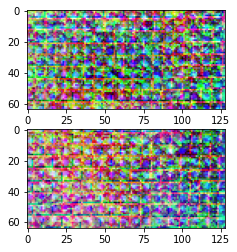

In [43]:
X, y = load_texture_dataset_xy(image_size = (128, 128), 
                               dataset_name = "Multiband_Brodatz_Texture")
    
X_train, y_train, X_test, y_test = split_dataset_by_pixel(X, y)

ax = plt.subplot(2, 1, 1)
plt.imshow(np.uint8(X_train[0]))

ax = plt.subplot(2, 1, 2)
plt.imshow(np.uint8(X_test[0]))

plt.show()

del X, y, X_train, y_train, X_test, y_test

In [44]:
def split_dataset_by_pixel_as_dataframe(X, y, split = DS_DEFAULT_PIXEL_SPLIT_RATIO):

    X_train, y_train, X_test, y_test = split_dataset_by_pixel(X, y, split)

    data_train = {"X": list(X_train),
                  "y": list(y_train)}

    data_test = {"X": list(X_test),
                  "y": list(y_test)}

    df_train = pd.DataFrame(data_train)

    df_test = pd.DataFrame(data_test)

    #print("X_train.shape = ", np.array(X_train).shape)

    return df_train, df_test

In [45]:
X, y = load_texture_dataset_xy(image_size = (128, 128), 
                               dataset_name = "Multiband_Brodatz_Texture")

df_train, df_test = split_dataset_by_pixel_as_dataframe(X, y)
          
del X, y, df_train, df_test


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (128, 128)
Total 154 images are loaded.

Splitting dataset into training and testing datasets ...
size of training dataset : 154
size of testing dataset : 154
training dataset shape: (154, 64, 128, 3)
testing dataset shape: (154, 64, 128, 3)


## Boostrapping new dataset for training and testing

In [46]:
import numpy as np
import pandas as pd
import os
import sys 
import imageio

#libpath = os.path.dirname(os.path.realpath(__file__)) + os.path.sep + ".." + os.path.sep + "lib" 
#sys.path.append(libpath)


def create_dataset_from_xy( *, 
                            X, 
                            y, 
                            dataset_path, 
                            subdir, 
                            imgaug,
                            n_images_per_class):
 
    print()
    print("dataset_path = ", dataset_path)
    print("subdir = ", subdir)
    print("n_images_per_class = ", n_images_per_class)

    for yi in y:
        #print(yi)
        yi_path = dataset_path + os.path.sep + subdir + os.path.sep + yi

        if not os.path.exists(yi_path):
            os.makedirs(yi_path)


    for i, (Xi, yi) in enumerate(zip(X, y)):
        yi_path = dataset_path + os.path.sep + subdir + os.path.sep + yi
        print(yi, end = ' ')
        Xi = np.expand_dims(Xi, axis = 0)
        for j in range(n_images_per_class):
            Xij = imgaug(Xi)
            Xij = Xij[0]
            Xij = np.array(Xij, dtype = np.uint8)
            Xij_name = yi_path + os.path.sep + f"{yi}_{j}.png"
            #print(Xij_name)
            imageio.imwrite(Xij_name, Xij)

    print()

In [53]:
def create_dataset( *,
                    dataset_name = "Multiband_Brodatz_Texture",
                    dataset_root = "datasets_new",
                    
                    output_size = (128, 128),
                   
                    n_train_images_per_class = 200,
                    n_test_images_per_class = 50,
                    seed = 1921
                    ):

    dataset_path = dataset_root + os.path.sep +  dataset_name
    #output_shape = (*output_shape, n_channels)

    print("dataset_path = ", dataset_path)
    print("output_size = ", output_size)
    print("n_train_images_per_class = ", n_train_images_per_class)
    print("n_test_images_per_class = ", n_test_images_per_class)

    # loading size
    image_size = (512, 512)
    #n_image_channels = 3
    
    X, y = load_texture_dataset_xy(
                                    image_size = image_size, 
                                    dataset_name = dataset_name
                                  )

    X_train, y_train, X_test, y_test = split_dataset_by_pixel(X, y)

    imgaug = CustomisedBootstrapImageAugmenter(  
                                        target_size = output_size,
                                        seed = seed
                                        )

    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    if not os.path.exists(dataset_path + os.path.sep + "train"):
        os.makedirs(dataset_path + os.path.sep + "train")

    if not os.path.exists(dataset_path + os.path.sep + "test"):
        os.makedirs(dataset_path + os.path.sep + "test")

    create_dataset_from_xy( X = X_train, 
                            y = y_train, 
                            dataset_path = dataset_path, 
                            subdir = "train",
                            imgaug = imgaug,
                            n_images_per_class = n_train_images_per_class)

    create_dataset_from_xy( X = X_test, 
                            y = y_test, 
                            dataset_path = dataset_path, 
                            subdir = "test",
                            imgaug = imgaug,
                            n_images_per_class = n_test_images_per_class)


    print()
    print("Completed!")
    print()



In [55]:
create_dataset( 
                    dataset_name = "Multiband_Brodatz_Texture",
                    dataset_root = "datasets_new",
                    output_size = (128, 128),
                    n_train_images_per_class = 200,
                    n_test_images_per_class = 50,
                  )

dataset_path =  datasets_new_tmp/Multiband_Brodatz_Texture
output_size =  (128, 128)
n_train_images_per_class =  200
n_test_images_per_class =  50

Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (512, 512)
Total 154 images are loaded.

Splitting dataset into training and testing datasets ...
size of training dataset : 154
size of testing dataset : 154
training dataset shape: (154, 256, 512, 3)
testing dataset shape: (154, 256, 512, 3)

dataset_path =  datasets_new_tmp/Multiband_Brodatz_Texture
subdir =  train
n_images_per_class =  200
Dz1 Dz10 Dz100 Dz101 Dz102 Dz103 Dz104 Dz105 Dz106 Dz107 Dz108 Dz109 Dz11 Dz110 Dz111 Dz112 Dz113 Dz114 Dz115 Dz116 Dz117 Dz118 Dz119 Dz12 Dz120 Dz121 Dz122 Dz123 Dz124 Dz125 Dz126 Dz127 Dz128 Dz129 Dz13 Dz130 Dz131 Dz132 Dz133 Dz134 Dz135 Dz136 Dz137 Dz138 Dz139 Dz14 Dz140 Dz141 Dz142 Dz143 Dz144 Dz145 Dz146 Dz147 Dz148 Dz149 Dz15 Dz150 Dz151 Dz152 Dz153 Dz154 Dz16 Dz17 Dz18 Dz19 Dz2 Dz20 Dz21 Dz22 Dz23 Dz24 Dz25 Dz26

# Optimising memory use

In [346]:
import gc

gc.collect()

64546

## Visualising the bootstrapped datasets

### Plotting dataset samples

In [74]:
import numpy as np
import matplotlib.pyplot as plt


""" We plot the sample images from the dataset. 
"""

def plot_dataset_samples(*,
                         df, 
                         nrows = 4, 
                         ncols = 4, 
                         subfig_height = 4, 
                         subfig_width = 4,
                        ):
    
    
    """ Plotting the samples 
    
    """

    figsize = (ncols * subfig_width, nrows * subfig_height) 
    #figsize = (15, 15) 

    

    """ Sampling
    
    """
    dfs = df.sample(n = nrows * ncols, replace = False)
    
    Xs = np.array(dfs["X"], dtype = object)
    ys = np.array(dfs["y"], dtype = object)
    
    
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    
    """ plt.subplots_adjust(left = 0.02,
                    right = 0.97,
                    bottom = 0.05,
                    hspace = 0.1,
                    wspace = 0.1,
                    top = 0.95)
    """

    axes_flat = axes.flat
    
    
    for row in range(nrows):
        for col in range(ncols):
            
            imgid = row * ncols + col
            
            img = Xs[imgid]
            #img = np.array(img, dtype = np.uint8) #print("img.shape", img.shape)
            
            
            label = ys[imgid]
            
            ax = axes_flat[row * ncols + col] 
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax.imshow(img, vmin = 0, vmax = 1) 
            #ax.imshow(img) 
            ax.title.set_text(f"{label} #{imgid}")

    plt.show()
    plt.close()


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (512, 512)
Total 154 images are loaded.


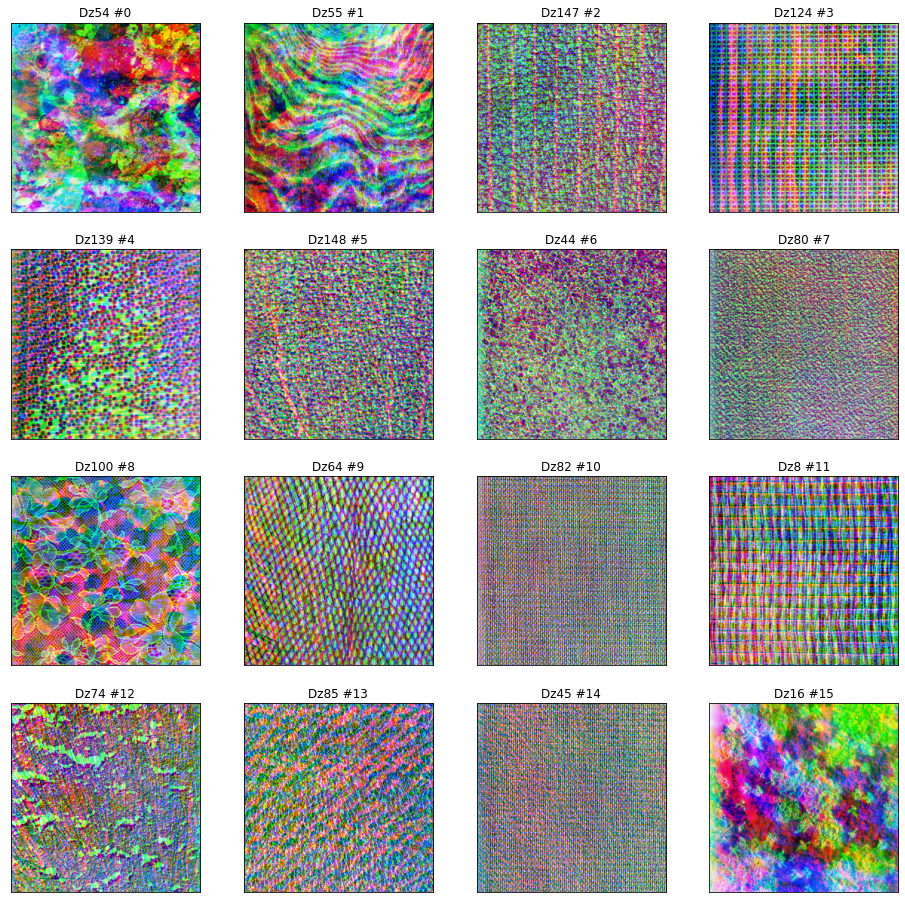

In [75]:
df = load_texture_dataset_as_dataframe(dataset_name = "Multiband_Brodatz_Texture")

df["X"] /= 255

plot_dataset_samples(    df = df, 
                         nrows = 4, 
                         ncols = 4, 
                         subfig_height = 4, 
                         subfig_width = 4,
                        )

del df

### Plotting augmented various samples

In [355]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_augmented_samples(*, 
                        X, 
                        y, 
                        img_augmenter, 
                        nrows = 2, 
                        ncols = 4, 
                        subfig_width = 4, 
                        subfig_height = 4,
                        savename = None
                    ):

    #X, y = next(iter(dataset))
    
    #X,y = load_mbt_dataset()

    #X_train, y_train, X_test, y_test = split_mbt_dataset(X, y)

    #img_augmenter = CustomisedUtilImageAugmenter()


    figsize = (ncols * subfig_width, nrows * subfig_height)

    
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    
    plt.subplots_adjust(left = 0.02, 
                        right = 0.98, 
                        bottom = 0.02, 
                        top = 0.98)

    """ plt.subplots_adjust(left = 0.02,
                    right = 0.97,
                    bottom = 0.05,
                    hspace = 0.1,
                    wspace = 0.1,
                    top = 0.95)
    """

    axes_flat = axes.flat


    for row in range(nrows):
        for col in range(ncols):

            imgid = row * ncols + col

            Xi = X[imgid, :, :, :]
            #Xi = X_train[3, :, :, :]
            Xi = Xi.copy()
            Xi = np.expand_dims(Xi, axis = 0)
            Xi = img_augmenter(Xi)
            #Xi = np.array(Xi, dtype = np.uint8)
            img = Xi[0, :, :, :]

            #img = X_train[imgid, :, :, :]
            #img = np.array(img, dtype = np.uint8) #print("img.shape", img.shape)

            label = y[imgid]

            ax = axes_flat[row * ncols + col]
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax.imshow(img, vmin = 0, vmax = 1.0)
            #ax.imshow(img)
            
            ax.title.set_text(f"{label} #{imgid}")

            
    if not os.path.exists("figures"):
        os.makedirs("figures")
            
    
    if savename:
        
        figpath = "figures" + os.path.sep + savename
        
        plt.savefig(figpath, 
                    dpi=600, 
                    format='pdf')
        
        print("saved to: ", figpath)
            
            
    plt.show()
    plt.close()


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (512, 512)
Total 154 images are loaded.
saved to:  figures/fig_augmented_samples.pdf


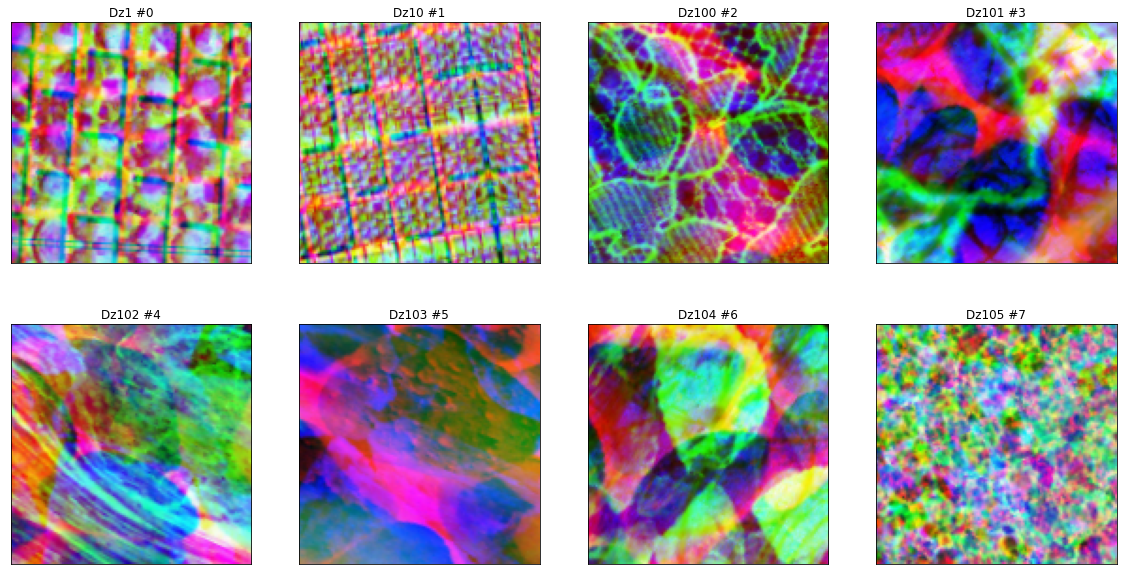

In [356]:
img_augmenter = CustomisedBootstrapImageAugmenter(  
                                        target_size = (128, 128),
                                        seed = 2113
                                    )

X, y = load_texture_dataset_xy(dataset_name = "Multiband_Brodatz_Texture")

plot_augmented_samples( 
                    X = X / 255, 
                    y = y, 
                    img_augmenter = img_augmenter, 
                    nrows = 2, 
                    ncols = 4, 
                    subfig_width = 4, 
                    subfig_height = 4,
                    savename = "fig_augmented_samples.pdf"
                )

del img_augmenter, X, y

In [357]:
def plot_augmented_samples_for_one_image(*, 
                                        X, 
                                        y, 
                                        img_augmenter, 
                                        nrows = 2, 
                                        ncols = 4, 
                                        subfig_width = 4, 
                                        subfig_height = 4,
                                        savename = None,
                                    ):
    
    
    
    #X, y = next(iter(dataset))
    
    #X,y = load_mbt_dataset()
    #X_train, y_train, X_test, y_test = split_mbt_dataset(X, y)
    
    #img_augmenter = CustomisedUtilImageAugmenter()
    
    
    figsize = (ncols * subfig_width, nrows * subfig_height) 
    
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    
    plt.subplots_adjust(left = 0.02, 
                        right = 0.98, 
                        bottom = 0.02, 
                        top = 0.98)
    
    """ plt.subplots_adjust(left = 0.02,
                    right = 0.97,
                    bottom = 0.05,
                    hspace = 0.1,
                    wspace = 0.1,
                    top = 0.95)
    """

    axes_flat = axes.flat
    
    indices = list(range(len(y)))
    idx = np.random.choice(indices)
    candidate_image = X[idx, :, :, :]
    
    
    
    for row in range(nrows):
        for col in range(ncols):
            
            plotid = row * ncols + col
            
            Xi = candidate_image.copy()
            Xi = np.expand_dims(Xi, axis = 0)
            Xi = img_augmenter(Xi)
            #Xi = np.array(Xi * 255, dtype = np.uint8)
            img = Xi[0, :, :, :]
    
            #img = X_train[imgid, :, :, :]
            #img = np.array(img, dtype = np.uint8) #print("img.shape", img.shape)
            
            label = y[idx]
            
            ax = axes_flat[row * ncols + col] 
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax.imshow(img, vmin = 0, vmax = 1.0) 
            #ax.imshow(img) 
            
            ax.title.set_text(f"{label} #{plotid}")

            
    if not os.path.exists("figures"):
        os.makedirs("figures")
            
    
    if savename:
        
        figpath = "figures" + os.path.sep + savename
        
        plt.savefig(figpath, 
                    dpi=600, 
                    format='pdf')
        
        print("saved to: ", figpath)
    
    plt.show()
    plt.close()


Loading dataset from path: datasets_orig/Multiband_Brodatz_Texture ...
image size:  (512, 512)
Total 154 images are loaded.
saved to:  figures/fig_augmented_samples_for_one_image.pdf


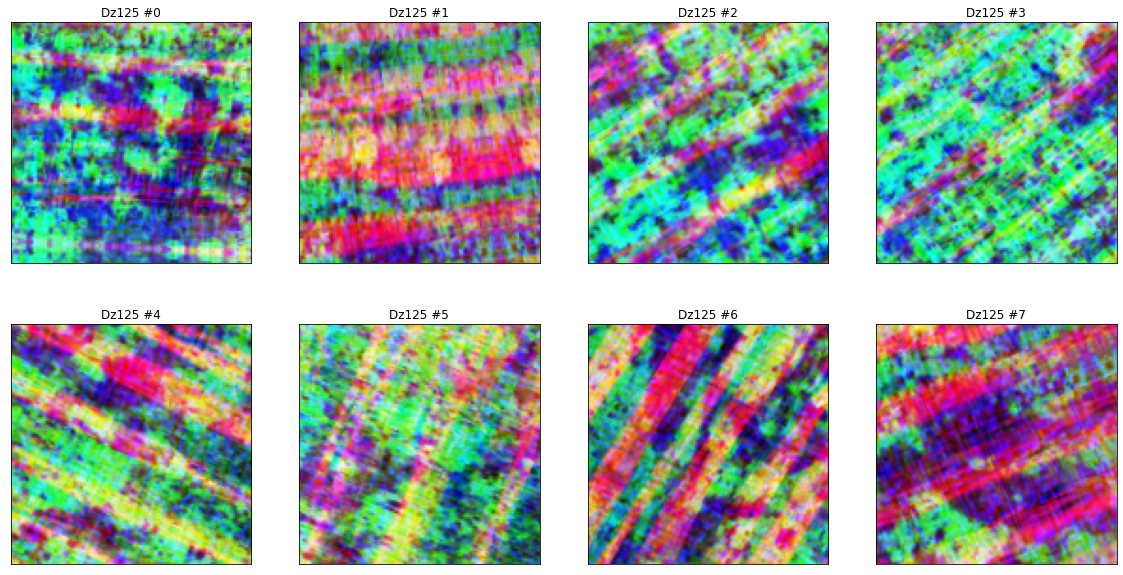

In [368]:
img_augmenter = CustomisedBootstrapImageAugmenter(  
                                        target_size = (128, 128),
                                        seed = 2113
                                    )

X, y = load_texture_dataset_xy(dataset_name = "Multiband_Brodatz_Texture")

plot_augmented_samples_for_one_image(
                                X = X / 255, 
                                y = y, 
                                img_augmenter = img_augmenter, 
                                nrows = 2, 
                                ncols = 4, 
                                subfig_width = 4, 
                                subfig_height = 4,
                                savename = "fig_augmented_samples_for_one_image.pdf"
                            )

del img_augmenter, X, y

# Loading the final training and testing datasets

## Loading datasets

In [3]:
train_dataset_ = tf.keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/train", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 2113
                )

Found 30800 files belonging to 154 classes.


In [4]:
test_dataset_ = tf.keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/test", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 3371
                )

Found 7700 files belonging to 154 classes.


In [5]:
n_classes = len(train_dataset_.class_names)
print("n_classes = ", n_classes)

n_classes =  154


In [6]:
n_train_samples = len(train_dataset_) * batch_size
n_train_batches = len(train_dataset_)

print("n_train_samples = ", n_train_samples)
print("n_train_batches = ", n_train_batches)

n_train_samples =  30848
n_train_batches =  241


In [7]:
n_test_samples = len(test_dataset_) * batch_size
n_test_batches = len(test_dataset_)

print("n_test_samples = ", n_test_samples)
print("n_test_batches = ", n_test_batches)

n_test_samples =  7808
n_test_batches =  61


In [8]:
n_samples = n_train_samples + n_test_samples
n_batches = n_train_batches + n_test_batches

print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_samples =  38656
n_batches =  302


## Normalising datasets and setting data prefetching

In [9]:
train_dataset = train_dataset_.map(lambda x, y: (x / 255., y))
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test_dataset_.map(lambda x, y: (x / 255., y))
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

## Verifying loaded dataset

In [92]:
x1 = next(iter(train_dataset))
x2 = x1[0]
x2.shape

TensorShape([128, 64, 64, 3])

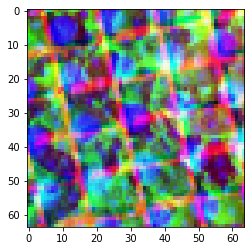

In [93]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

# Image augmentation model

## Random color affine transformation layer

Random color affine transformation is crucial to avoid trivial solution of merely learning classification from color histogram information!

In [10]:
 # We make it working with keras model save and load
# ref: 
# https://keras.io/guides/serialization_and_saving/
# https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
# https://keras.io/examples/vision/semisupervised_simclr/

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing as keras_preprocessing_layers

class CustomisedRandomColorAffineLayer(keras.layers.Layer):

    def __init__(self, 
                 brightness = 0, 
                 jitter = 0, 
                 name = 'color_affine',
                 **kwargs):

        self.brightness = brightness
        self.jitter = jitter
 
        super(CustomisedRandomColorAffineLayer, self).__init__(**kwargs)
        

    def get_config(self):
        
        config = super().get_config()

        config['brightness'] = self.brightness
        config['jitter'] = self.jitter

        #print("config = ", config)

        return config

    #@classmethod
    #def from_config(cls, config):
    #    return cls(**config)

    def call(self, images, training = True):
        if training:
            batch_size = tf.shape(images)[0]

            # For each pixels, we randomly adjust their brightnesses.
            brightness_scales = 1 + tf.random.uniform(
                            (batch_size, 1, 1, 1), 
                            minval = -self.brightness, 
                            maxval = self.brightness
                        )

            # Different for all colors
            jitter_matrices = tf.random.uniform(
                            (batch_size, 1, 3, 3), 
                            minval = -self.jitter, 
                            maxval = self.jitter
                        )

            color_transforms = (
                            tf.eye(3, batch_shape = [batch_size, 1]) * brightness_scales
                                + jitter_matrices
                        )

            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        
        return images

## Image augmentation model for train

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing as keras_preprocessing_layers


class CustomisedTrainImageAugmenter(keras.layers.Layer):
    def __init__(self, 
                 min_area,
                 brightness,
                 jitter,
                 name = 'train_imgaug_layer',
                 **kwargs):

        #self.image_shape = image_shape
        self.min_area = min_area
        self.brightness = brightness
        self.jitter = jitter


        #self.zoom_factor = 1.0 - tf.sqrt(min_area)
        self.zoom_factor = 1.0 - np.sqrt(min_area)

        self.model = keras.Sequential(
           [
            #keras.layers.InputLayer(input_shape = image_shape),
            #keras_preprocessing_layers.Rescaling(1 / 255),
            keras_preprocessing_layers.RandomFlip("horizontal_and_vertical"),
            keras_preprocessing_layers.RandomTranslation(
                                            self.zoom_factor / 2, 
                                            self.zoom_factor / 2
                                           ),
            keras_preprocessing_layers.RandomZoom(
                                            (-self.zoom_factor, 0.0), 
                                            (-self.zoom_factor, 0.0)
                                        ),
            CustomisedRandomColorAffineLayer(   
                                            brightness = brightness, 
                                            jitter = jitter, 
                                            name = "color_affine_for_train"
                                        ),
            ],
            name = "train_imgaug_model"
          )

        super(CustomisedTrainImageAugmenter, self).__init__(name = name, **kwargs)

    def get_config(self):
        config = super().get_config()
        
        #config['image_shape'] = self.image_shape
        config['min_area'] = self.min_area
        config['brightness'] = self.brightness
        config['jitter'] = self.jitter
        config['zoom_factor'] = self.zoom_factor
        config['model'] = self.model

        #print(config)

        return config

    def call(self, images, training = True):
        if training:
            outputs = self.model(images)
        else:
            outputs = images

        return outputs

    @classmethod
    def from_config(cls, config):
        return cls(**config)




# Visualising image augmentation

## Plotting augmented various samples

saved to:  figures/fig_augmented_samples_for_train.pdf


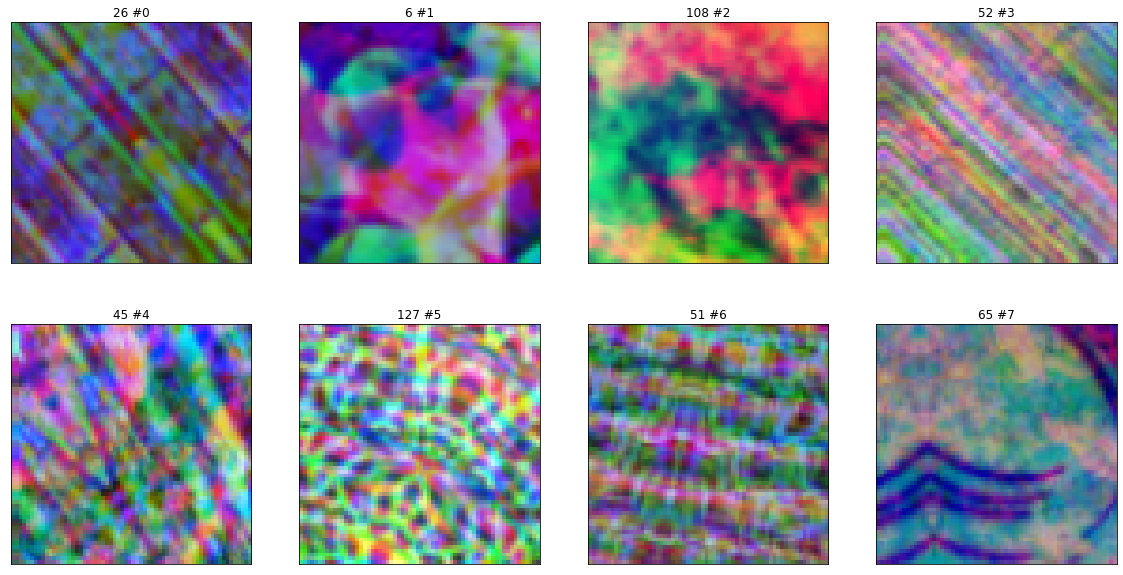

In [371]:
img_augmenter = CustomisedTrainImageAugmenter(**imgaug_params)


X, y = next(iter(train_dataset))

X = X.numpy().astype("float32") 

plot_augmented_samples( 
                        X = X, 
                        y = y, 
                        img_augmenter = img_augmenter, 
                        nrows = 2, 
                        ncols = 4, 
                        subfig_width = 4, 
                        subfig_height = 4,
                        savename = "fig_augmented_samples_for_train.pdf"
                    )

del img_augmenter, X, y

## Plotting augmented samples for one image

saved to:  figures/fig_augmented_samples_for_one_image_for_train.pdf


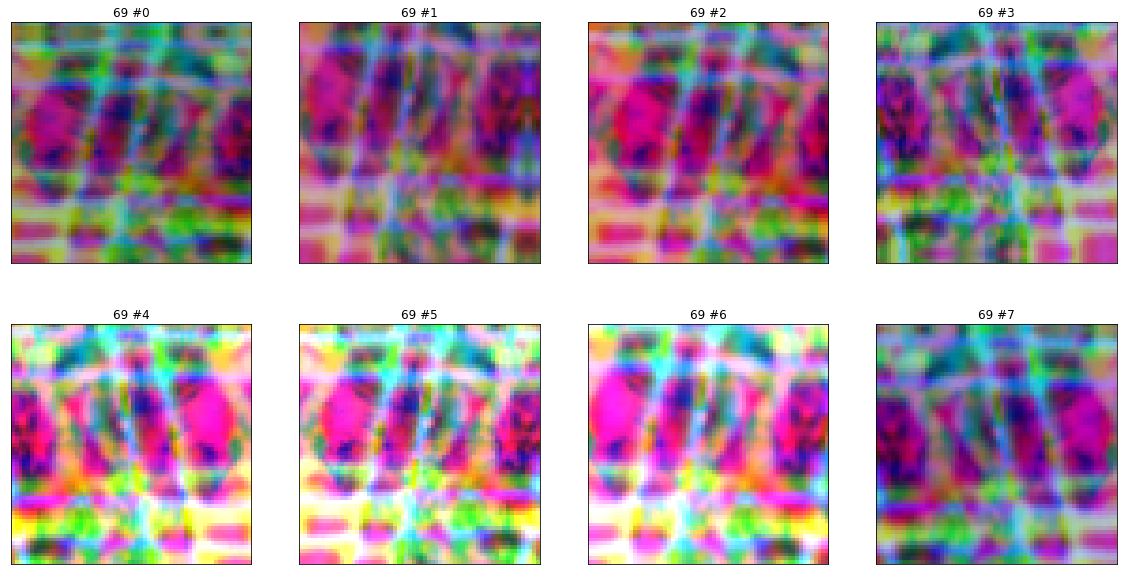

In [372]:
img_augmenter = CustomisedTrainImageAugmenter(**imgaug_params)

X, y = next(iter(train_dataset))

X = X.numpy().astype("float32") 

plot_augmented_samples_for_one_image(
                                X = X, 
                                y = y, 
                                img_augmenter = img_augmenter, 
                                nrows = 2, 
                                ncols = 4, 
                                subfig_width = 4, 
                                subfig_height = 4,
                                savename = "fig_augmented_samples_for_one_image_for_train.pdf"
                            )

del img_augmenter, X, y

# Building supervised learning model with specified encoder

In [277]:
def build_supervised_model( *,
                            learning_rate = 0.001,
                            image_shape,      
                            n_classes,
                            encoder, 
                            image_augmenter,
                            name
                           ):
    
    newhead = keras.Sequential(
                [
                    keras.layers.Dense(512, activation="relu", name = "hidden_1"),
                    keras.layers.Dense(512, activation="relu", name = "hidden_2"),
                    keras.layers.Dense(n_classes, name = "output"), 
                ], 
                name = "newhead"
            )
            
    
    model = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape = image_shape),
                image_augmenter, #CustomisedTrainImageAugmenter(**imgaug_params),
                encoder,
                newhead
            ],
            name = name,
        )

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = [
                        keras.metrics.SparseCategoricalAccuracy(name = "accuracy"),
                        keras.metrics.SparseTopKCategoricalAccuracy(5, name="accuracy_top-5"),
                      ],
        )
    
    #print()
    #newhead.summary()
    
    #print()
    #encoder.summary()
    
    #print()
    #model.summary()
    
    return model

# A framework of training, evaluating and saving

In [294]:
import os
import pickle


def train_evaulate_and_save_models(*,
                   model,
                   encoder,
                   train_dataset,
                   test_dataset,
                   epochs,
                   savename,
                  ):
    
    
    
    checkpoint_filepath = "checkpoints" + os.path.sep + savename
    
    if not os.path.exists(checkpoint_filepath):
        os.makedirs(checkpoint_filepath)
        
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only = False,
        save_weights_only = True,
        
    )
    
    print()
    print("Training ...")
    print()
    
    history_train = model.fit(
                    train_dataset, 
                    epochs = epochs,
                    validation_data = test_dataset,
                    verbose = 1,
                    #callbacks = [checkpoint_callback],
                   )
    
    #loading the checkpoint
    #model.load_weights(checkpoint_filepath)
    
    savepath = "models" + os.path.sep + savename
    
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    
    
    print()
    print("Saving models ...")
    print()
    
    encoder.save(savepath + os.path.sep + "encoder.saved_model")
    
    
     #a tensorflow bug, must call the model first then
    _ = model(next(iter(train_dataset))[0])
    model.save(savepath + os.path.sep + "main.saved_model")

    print()
    print("Saving training history data ...")
    print()

    if not os.path.exists("results" + os.path.sep + savename):
        os.makedirs("results" + os.path.sep + savename)
        
    pickle.dump(history_train.history, 
            open("results" + os.path.sep + savename + os.path.sep + "history_train.pickle", "wb" ))

    print()
    print("Results:")
    print()
    history = history_train.history
    for k in history:
        
        if "loss" in k:
            continue
        
        max_v = float(max(history[k]))
        
        print(f"Maximal {k}: {max_v:.5f}")
        
    
    print()
    print("-- Completed --")
    print()

# The facilities of plotting results

In [15]:
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import cycle

#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_train_results(
                                resultfile, 
                                title,
                                ylabel,
                                keys,
                                labels,
                                savename = None,
                                legend_location = "best",
                                normalise = False
                            ):
    
    if not os.path.exists(resultfile):
        return

    
    
    #fig_width = 10.
    #fig_height = fig_width*0.5
    #
    #fig = plt.figure(figsize=(fig_width, fig_height))
    #
    #
    #plt.subplots_adjust(left = 0.1, 
    #                    right = 0.9, 
    #                    bottom = 0.15, 
    #                    top = 0.9)

    fig_width = 8.5
    fig_height = fig_width*0.5

    fig = plt.figure(figsize=(fig_width, fig_height))

    
    plt.subplots_adjust(left = 0.1, 
                        right = 0.95, 
                        bottom = 0.15, 
                        top = 0.95)
    
    
    history = pickle.load(open(resultfile, "rb"))

    n = len(keys)
    #colours = iter(cm.rainbow(np.linspace(0, 1, n)))
    colours = iter(cm.Set1(np.linspace(0, 1, n)))
    
    markers = cycle(["v", "^", "s", "<", ">", "D"])
    
    for k, label in zip(keys, labels):
        if k not in history:
            print(f"key {k} not found")
            continue
            
        v = history[k]
        
        if normalise:
            v = np.array(v) / max(v)
        
        c = next(colours)
        m = next(markers)
        
        #plt.plot(v, color = c, label = label, linewidth = 2)
        plt.plot(
                    v, 
                    color = c, 
                    label = label, 
                    linewidth = 2.5, 
                    #linestyle = ls,
                    marker = m,
                    markersize = 9
                )
        
    
    plt.xlabel("# of epochs", fontsize = 12)
    
    plt.ylabel(ylabel, fontsize = 12)
    
    k = list(keys)[0]
    v = history[k]
    plt.xlim(0, len(v) - 1)
    plt.ylim(0, 1.3)

    xticks = np.linspace(0, 
                     len(v) - 1, 
                     num = len(v), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)
    plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

    plt.grid()
    
    plt.legend(
            loc = legend_location, #'upper center',
            fontsize = 12,
            ncol = 3, 
            frameon = False)
    
    if not os.path.exists("figures"):
        os.makedirs("figures")
        
    if savename:
        figpath = "figures" + os.path.sep + savename
        plt.savefig(figpath, 
                    dpi=600, 
                    format='pdf')
        
        print("saved to: ", figpath)
    
    plt.title(title)

    plt.show()

# Baseline: Supervised learning with simple encoder

## Building simple encoder

In [276]:
def build_simple_encoder(image_shape):
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=image_shape),
            
            keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu"),
            keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Conv2D(128, kernel_size=3, strides=2, activation="relu"),            
            keras.layers.Conv2D(256, kernel_size=3, strides=2, activation="relu"), 
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Flatten(),
            
        ],
        
        name = "encoder_simple",
    )

## Building model

In [279]:
baseline_simple_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)
baseline_simple_encoder = build_simple_encoder(image_shape)

baseline_simple_model = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_simple, 
                           image_augmenter = baseline_simple_imgaug,
                           name = "baseline_simple_model",
                           learning_rate = 0.001)

## Training from scratch

In [280]:
train_evaulate_and_save_models(
                   model = baseline_simple_model,
                   encoder = baseline_simple_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "baseline_simple",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 53s 214ms/step - loss: 0.7938 - accuracy: 0.8040 - accuracy_top-5: 0.9220 - val_loss: 1.1209 - val_accuracy: 0.7174 - val_accuracy_top-5: 0.9369
Epoch 2/20
241/241 [==============================] - 52s 214ms/step - loss: 0.1690 - accuracy: 0.9431 - accuracy_top-5: 0.9982 - val_loss: 0.8526 - val_accuracy: 0.8052 - val_accuracy_top-5: 0.9577
Epoch 3/20
241/241 [==============================] - 58s 238ms/step - loss: 0.1324 - accuracy: 0.9569 - accuracy_top-5: 0.9992 - val_loss: 1.2039 - val_accuracy: 0.7466 - val_accuracy_top-5: 0.9403
Epoch 4/20
241/241 [==============================] - 60s 247ms/step - loss: 0.1204 - accuracy: 0.9615 - accuracy_top-5: 0.9996 - val_loss: 0.9634 - val_accuracy: 0.7766 - val_accuracy_top-5: 0.9629
Epoch 5/20
241/241 [==============================] - 51s 211ms/step - loss: 0.1088 - accuracy: 0.9644 - accuracy_top-5: 0.9994 - val_loss: 2.3881 - val_accuracy: 0.6212 - val_accuracy_top-

INFO:tensorflow:Assets written to: models/baseline_simple/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_simple/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_simple/main.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_simple/main.saved_model/assets



Saving training history data ...


Results:

Maximal accuracy: 0.98172
Maximal accuracy_top-5: 0.99994
Maximal val_accuracy: 0.85429
Maximal val_accuracy_top-5: 0.97416

-- Completed --



## Testing of loading models

In [ ]:
test_encoder = keras.models.load_model("models/baseline_simple/encoder.saved_model")
test_model = keras.models.load_model("models/baseline_simple/main.saved_model")

del test_encoder
del test_model

In [176]:
history = pickle.load(open(b"results/baseline_simple/history_train.pickle", "rb"))
del history

## Plotting results

saved to:  figures/fig_baseline_simple_accuracy.pdf


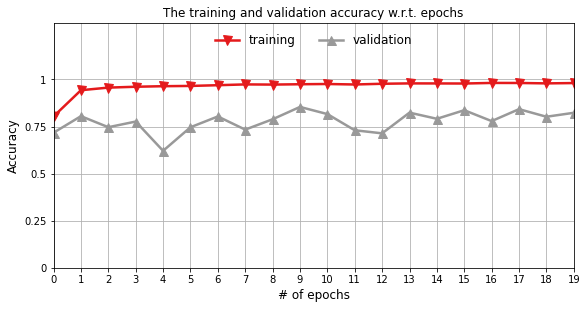

In [16]:
plot_train_results(
                resultfile = "results/baseline_simple/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["accuracy", "val_accuracy"],
                labels = ["training", "validation"],
                savename = "fig_baseline_simple_accuracy.pdf",
                legend_location = "upper center",
                normalise = False
            )

saved to:  figures/fig_baseline_simple_accuracy_top5.pdf


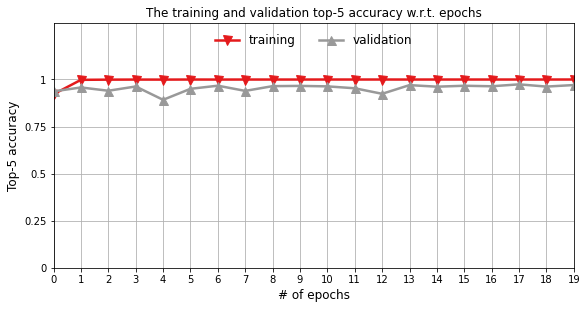

In [17]:
plot_train_results(
                resultfile = "results/baseline_simple/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["accuracy_top-5", "val_accuracy_top-5"],
                labels = ["training", "validation"],
                savename = "fig_baseline_simple_accuracy_top5.pdf",
                legend_location = "upper center",
                normalise = False
            )

# Baseline: Supervised learning with VGG16

## Building VGG16 encoder

In [281]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

def build_vgg16_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
     
    #x = keras.layers.Lambda(vgg16_preprocess_input)(inputs)
    
    model_orig = VGG16(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   

    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "vgg16_encoder")
    
    return model_new

## Building model

In [282]:
baseline_vgg16_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)
baseline_vgg16_encoder = build_vgg16_encoder(image_shape)
baseline_vgg16_encoder.trainable = False

baseline_vgg16_model = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_vgg16_encoder, 
                           image_augmenter = baseline_vgg16_imgaug,
                           name = "baseline_vgg16_model",
                           learning_rate = 0.001)

## Training

In [283]:
train_evaulate_and_save_models(
                   model = baseline_vgg16_model,
                   encoder = baseline_vgg16_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "baseline_vgg16",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 467s 2s/step - loss: 2.1863 - accuracy: 0.4098 - accuracy_top-5: 0.7435 - val_loss: 1.7301 - val_accuracy: 0.4761 - val_accuracy_top-5: 0.8473
Epoch 2/20
241/241 [==============================] - 461s 2s/step - loss: 1.0717 - accuracy: 0.6546 - accuracy_top-5: 0.9430 - val_loss: 1.7708 - val_accuracy: 0.4849 - val_accuracy_top-5: 0.8447
Epoch 3/20
241/241 [==============================] - 463s 2s/step - loss: 0.8569 - accuracy: 0.7181 - accuracy_top-5: 0.9644 - val_loss: 1.6621 - val_accuracy: 0.5210 - val_accuracy_top-5: 0.8716
Epoch 4/20
241/241 [==============================] - 452s 2s/step - loss: 0.7524 - accuracy: 0.7493 - accuracy_top-5: 0.9745 - val_loss: 1.6586 - val_accuracy: 0.5304 - val_accuracy_top-5: 0.8765
Epoch 5/20
241/241 [==============================] - 450s 2s/step - loss: 0.6838 - accuracy: 0.7725 - accuracy_top-5: 0.9779 - val_loss: 1.5562 - val_accuracy: 0.5538 - val_accuracy_top-5: 0.8925


INFO:tensorflow:Assets written to: models/baseline_vgg16/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_vgg16/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_vgg16/main.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_vgg16/main.saved_model/assets



Saving training history data ...


Results:

Maximal accuracy: 0.85448
Maximal accuracy_top-5: 0.99244
Maximal val_accuracy: 0.60532
Maximal val_accuracy_top-5: 0.90662

-- Completed --



## Plotting results

saved to:  figures/fig_baseline_vgg16_accuracy.pdf


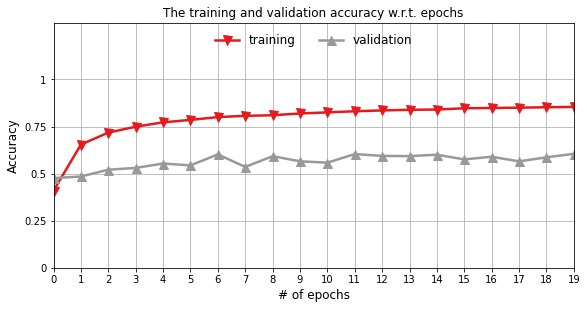

In [18]:
plot_train_results(
                resultfile = "results/baseline_vgg16/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["accuracy", "val_accuracy"],
                labels = ["training", "validation"],
                savename = "fig_baseline_vgg16_accuracy.pdf",
                legend_location = "upper center",
                normalise = False
            )

saved to:  figures/fig_baseline_vgg16_accuracy_top5.pdf


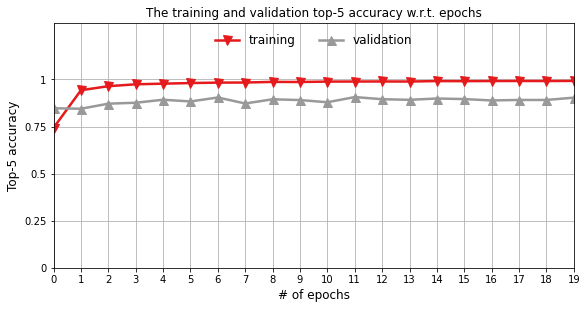

In [19]:
plot_train_results(
                resultfile = "results/baseline_vgg16/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["accuracy_top-5", "val_accuracy_top-5"],
                labels = ["training", "validation"],
                savename = "fig_baseline_vgg16_accuracy_top5.pdf",
                legend_location = "upper center",
                normalise = False
            )

# Baseline: Supervised learning with ResNet50

## Building ResNet50 encoder

In [284]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

def build_resnet50_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    #x = tf.keras.layers.Lambda(resnet50_preprocess_input)(inputs)
    
    model_orig = ResNet50(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
      
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "resnet50_encoder")
    
    return model_new

## Building model

In [285]:
baseline_resnet_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)

baseline_resnet_encoder = build_resnet50_encoder(image_shape)
baseline_resnet_encoder.trainable = False


baseline_resnet_model = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_resnet_encoder, 
                           image_augmenter = baseline_resnet_imgaug,
                           name = "baseline_resnet_model",
                           learning_rate = 0.001)

## Training

In [286]:
train_evaulate_and_save_models(
                   model = baseline_resnet_model,
                   encoder = baseline_resnet_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "baseline_resnet",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 233s 948ms/step - loss: 4.5451 - accuracy: 0.0314 - accuracy_top-5: 0.1317 - val_loss: 4.0374 - val_accuracy: 0.0523 - val_accuracy_top-5: 0.2010
Epoch 2/20
241/241 [==============================] - 241s 996ms/step - loss: 3.8605 - accuracy: 0.0714 - accuracy_top-5: 0.2698 - val_loss: 4.0545 - val_accuracy: 0.0558 - val_accuracy_top-5: 0.2364
Epoch 3/20
241/241 [==============================] - 227s 939ms/step - loss: 3.6530 - accuracy: 0.0949 - accuracy_top-5: 0.3277 - val_loss: 4.2026 - val_accuracy: 0.0596 - val_accuracy_top-5: 0.2452
Epoch 4/20
241/241 [==============================] - 232s 963ms/step - loss: 3.5193 - accuracy: 0.1191 - accuracy_top-5: 0.3691 - val_loss: 4.7043 - val_accuracy: 0.0656 - val_accuracy_top-5: 0.2213
Epoch 5/20
241/241 [==============================] - 208s 864ms/step - loss: 3.4487 - accuracy: 0.1279 - accuracy_top-5: 0.3946 - val_loss: 4.2191 - val_accuracy: 0.0732 - val_accuracy

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/baseline_resnet/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_resnet/encoder.saved_model/assets
/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/baseline_resnet/main.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_resnet/main.saved_model/assets



Saving training history data ...


Results:

Maximal accuracy: 0.22104
Maximal accuracy_top-5: 0.55231
Maximal val_accuracy: 0.13844
Maximal val_accuracy_top-5: 0.39325

-- Completed --



## Plotting results

saved to:  figures/fig_baseline_resnet_accuracy.pdf


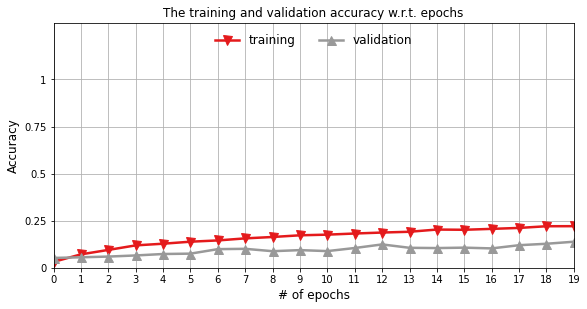

In [20]:
plot_train_results(
                resultfile = "results/baseline_resnet/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["accuracy", "val_accuracy"],
                labels = ["training", "validation"],
                savename = "fig_baseline_resnet_accuracy.pdf",
                legend_location = "upper center",
                normalise = False
            )

saved to:  figures/fig_baseline_resnet_accuracy_top5.pdf


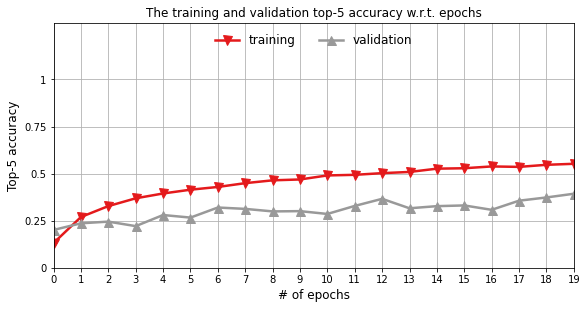

In [21]:
plot_train_results(
                resultfile = "results/baseline_resnet/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["accuracy_top-5", "val_accuracy_top-5"],
                labels = ["training", "validation"],
                savename = "fig_baseline_resnet_accuracy_top5.pdf",
                legend_location = "upper center",
                normalise = False
            )

# Baseline: Supervised learning with MobileNet

## Building MobileNet encoder

In [287]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input

def build_mobilenet_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    #x = tf.keras.layers.Lambda(resnet50_preprocess_input)(inputs)
    
    model_orig = MobileNet(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
      
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "mobilenet_encoder")
    
    return model_new

## Building model

In [288]:
baseline_mobilenet_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)

baseline_mobilenet_encoder = build_mobilenet_encoder(image_shape)
baseline_mobilenet_encoder.trainable = False


baseline_mobilenet_model = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_mobilenet_encoder, 
                           image_augmenter = baseline_mobilenet_imgaug,
                           name = "baseline_mobilenet_model",
                           learning_rate = 0.001)

## Training

In [289]:
train_evaulate_and_save_models(
                   model = baseline_mobilenet_model,
                   encoder = baseline_mobilenet_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "baseline_mobilenet",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 64s 260ms/step - loss: 2.4931 - accuracy: 0.3477 - accuracy_top-5: 0.6658 - val_loss: 2.2340 - val_accuracy: 0.3710 - val_accuracy_top-5: 0.7335
Epoch 2/20
241/241 [==============================] - 67s 279ms/step - loss: 1.7051 - accuracy: 0.4984 - accuracy_top-5: 0.8263 - val_loss: 2.1422 - val_accuracy: 0.4055 - val_accuracy_top-5: 0.7561
Epoch 3/20
241/241 [==============================] - 66s 272ms/step - loss: 1.5596 - accuracy: 0.5334 - accuracy_top-5: 0.8530 - val_loss: 2.1210 - val_accuracy: 0.4112 - val_accuracy_top-5: 0.7708
Epoch 4/20
241/241 [==============================] - 66s 272ms/step - loss: 1.4793 - accuracy: 0.5541 - accuracy_top-5: 0.8654 - val_loss: 2.0638 - val_accuracy: 0.4256 - val_accuracy_top-5: 0.7782
Epoch 5/20
241/241 [==============================] - 66s 273ms/step - loss: 1.4380 - accuracy: 0.5682 - accuracy_top-5: 0.8699 - val_loss: 2.0302 - val_accuracy: 0.4339 - val_accuracy_top-

INFO:tensorflow:Assets written to: models/baseline_mobilenet/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_mobilenet/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_mobilenet/main.saved_model/assets


INFO:tensorflow:Assets written to: models/baseline_mobilenet/main.saved_model/assets



Saving training history data ...


Results:

Maximal accuracy: 0.63760
Maximal accuracy_top-5: 0.90649
Maximal val_accuracy: 0.47013
Maximal val_accuracy_top-5: 0.80468

-- Completed --



## Plotting results

saved to:  figures/fig_baseline_mobilenet_accuracy.pdf


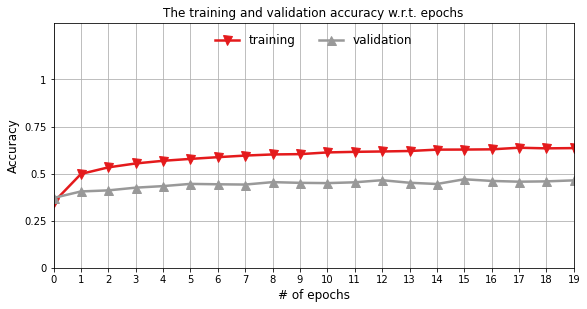

In [22]:
plot_train_results(
                resultfile = "results/baseline_mobilenet/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["accuracy", "val_accuracy"],
                labels = ["training", "validation"],
                savename = "fig_baseline_mobilenet_accuracy.pdf",
                legend_location = "upper center",
                normalise = False
            )

saved to:  figures/fig_baseline_mobilenet_accuracy_top5.pdf


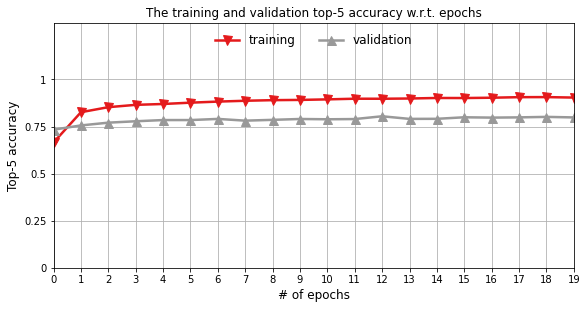

In [23]:
plot_train_results(
                resultfile = "results/baseline_mobilenet/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["accuracy_top-5", "val_accuracy_top-5"],
                labels = ["training", "validation"],
                savename = "fig_baseline_mobilenet_accuracy_top5.pdf",
                legend_location = "upper center",
                normalise = False
            )

# Contrastive learning model

In [334]:
#We refer the framework from https://keras.io/examples/vision/semisupervised_simclr/


import numpy as np

import tensorflow as tf
from tensorflow import keras


class ContrastiveModel(keras.Model):
    def __init__(self,
                 *,
                 temperature = 0.5,
                 
                 contrastive_loss_func = None, #use default loss
                 
                 encoder = None,

                 projhead_hidden_dims = (512, 512,), #one hidden layer by default
                 projhead_hidden_activation = "swish", 
                 projhead_output_dim = 512,      #one linear output layer
                
                 image_augmenter,   

                 n_classes,  #number of classes, used for linear-regression metric
                 
                 
                 **kwargs
                 ):
        
        
        #contrastive_loss_name_to_func_dict = {
        #                    "infonce": self.infonce_contrastive_loss_func,               
        #                    #"npairs": self.npairs_contrastive_loss_func
        #            }
        
        #assert (contrastive_loss_func in contrastive_loss_name_to_func_dict), 
        #                "invalid contrastive_loss_func"
        
        super(ContrastiveModel, self).__init__(**kwargs)

        self.temperature = temperature

        self.image_augmenter = image_augmenter
        
        self.encoder = encoder
        
        self.n_classes = n_classes
        
        self.projhead_input_shape = self.encoder.layers[-1].output.shape[1]
        self.projhead_hidden_dims = projhead_hidden_dims
        self.projhead_hidden_activation = projhead_hidden_activation
        self.projhead_output_dim = projhead_output_dim
        
        #print("projhead_input_shape = ", self.projhead_input_shape)
        #print("projhead_hidden_dims = ", self.projhead_hidden_dims)
        #print("projhead_hidden_activation = ", self.projhead_hidden_activation)
        #print("projhead_output_dim = ", self.projhead_output_dim)


        # build projection head
        self.projhead_model = self.build_projhead_model(
                                input_shape = self.projhead_input_shape,
                                hidden_dims = self.projhead_hidden_dims,
                                output_dim = self.projhead_output_dim
                              )


        # Single dense layer for linear probing
        self.probe_model = self.build_probe_model(
                                n_classes = self.n_classes,
                                input_shape = self.projhead_output_dim
                              )
       
        #self.encoder.summary()
        #self.projhead_model.summary()
        #self.probe_model.summary()

        
        if not contrastive_loss_func:
            self.contrastive_loss_func = self.infonce_contrastive_loss_func
        else:
            self.contrastive_loss_func = contrastive_loss_func
     
    
    
    
    def build_probe_model(self, *, n_classes, input_shape):
        return keras.Sequential(
                [
                 keras.layers.InputLayer(input_shape = input_shape), 
                 keras.layers.Dense(n_classes), #pure linear
                ], 
                 name="linear_probe"
                )
 
    def build_projhead_model(self, *, input_shape, hidden_dims, output_dim):
        
        inputs = keras.layers.Input(shape = input_shape, name = "projhead_input")

        x = keras.layers.Flatten(name = "projhead_flatten")(inputs)
        
        if not self.projhead_hidden_activation:
            self.projhead_hidden_activation = "swish"
        
        for idx, dim in enumerate(hidden_dims):
            x = keras.layers.Dense(dim, 
                                   activation = self.projhead_hidden_activation, 
                                   name = f"projhead_hidden_{idx+1}")(x)

        outputs = keras.layers.Dense(output_dim)(x)

        model = keras.Model(inputs = inputs, outputs = outputs, name = "projhead_output")

        return model

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):

        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(
                                                    name="contrastive_loss"
                                                )
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
                                                    name="contrastive_accuracy"
                                                )
        self.contrastive_accuracy_top5 = keras.metrics.SparseTopKCategoricalAccuracy(
                                                    5, 
                                                    name="contrastive_accuracy_top-5"
                                                )
        

        self.probe_loss_tracker = keras.metrics.Mean(
                                                    name="probe_loss"
                                                )
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(
                                                    name="probe_accuracy"
                                                )

        self.probe_accuracy_top5 = keras.metrics.SparseTopKCategoricalAccuracy(
                                                    5,
                                                    name="probe_accuracy_top-5"
                                                )
        
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker, #contrastive loss
            
            self.contrastive_accuracy, #contrastive accuracy
            self.contrastive_accuracy_top5,
            
            self.probe_loss_tracker, #linear prober loss
            
            self.probe_accuracy, #linear prober accuracy
            self.probe_accuracy_top5,
        ]

        
    def infonce_contrastive_loss_func(self, projections_1, projections_2):
        
        # We first normalise the projections for the two batches.
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        # Computing A * B^T, all similarities will be computed at this point.
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        
        fake_labels = tf.range(batch_size)
         
        # Update the projection head accuracy
        self.contrastive_accuracy.update_state(fake_labels, similarities)
        self.contrastive_accuracy.update_state(fake_labels, tf.transpose(similarities))

        self.contrastive_accuracy_top5.update_state(fake_labels, similarities)
        self.contrastive_accuracy_top5.update_state(fake_labels, tf.transpose(similarities))


        
        # Compute the loss
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, similarities, from_logits=True
        )
        
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, tf.transpose(similarities), from_logits=True
        )

        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
     
        #unpacking the training images and labels (fake) in the batch
        images,labels = data
    
        
        """ The contrastive learning episode
        
        """
        
        # We randomly sample two transformation functions
        # and use them to augment the input batch (N images).
        augmented_images_1 = self.image_augmenter(images)
        augmented_images_2 = self.image_augmenter(images)
        
        
        # We now have 2*N augmented images
        
        
        # tf.GradientTape is a basic facility in tensorflow, which implemented 
        # of recording operations for automatic differentiation..
        #
        # ref: https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # ref:
        
        # Create a GradientTape instance to record the forward process
        with tf.GradientTape() as tape:
            # Feeding augmented images (2*N) into the base encoder
            # to extract their features (2*N)
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            
            # Feeding the features (2*N) into the projection head, which is 
            # a MLP, the final layer is a pure linear layer.
            projections_1 = self.projhead_model(features_1)
            projections_2 = self.projhead_model(features_2)
            
            # We now have 2*N projections from the projection head
            # and compute the contrastive loss (info-NCE)
            contrastive_loss = self.contrastive_loss_func(projections_1, projections_2)
            
        # Computing the gradients w.r.t. every trainable variables by back-propogating the errors    
        # the *gradients* has the results with the form dL / dW
        gradients = tape.gradient(
                contrastive_loss,
                self.encoder.trainable_weights + self.projhead_model.trainable_weights,
            )
        
        # Optimising the weights by the computed gradients.
        self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.encoder.trainable_weights + self.projhead_model.trainable_weights,
                )
            )
        
            
        # Updating the loss history.
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        """ Updating the weights of the linear prediction model
        
        """
                        
        augmented_images_3 = self.image_augmenter(images)
        
        # Forward
        with tf.GradientTape() as tape:
            
            features = self.encoder(augmented_images_3)
            
            features_2 = self.projhead_model(features)
                      
            class_logits = self.probe_model(features_2)
            
            probe_loss = self.probe_loss(labels, class_logits)
            
            
        # backwards, computing the gradients w.r.t. the linear prober
        gradients = tape.gradient(probe_loss, self.probe_model.trainable_weights)
        
        # updating the weights.
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.probe_model.trainable_weights)
        )
        
        # updating history.
        self.probe_loss_tracker.update_state(probe_loss)
        
        self.probe_accuracy.update_state(labels, class_logits)
        self.probe_accuracy_top5.update_state(labels, class_logits)
        
        
        return {m.name: m.result() for m in self.metrics}

    # for validation
    def test_step(self, data):
        
        images, labels = data

        # Update probe
        augmented_images = self.image_augmenter(images, training=False)
        
        features = self.encoder(augmented_images, training=False)
        features_2 = self.projhead_model(features, training=False)
        
        class_logits = self.probe_model(features_2, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        
        self.probe_loss_tracker.update_state(probe_loss)
        
        self.probe_accuracy.update_state(labels, class_logits)
        self.probe_accuracy_top5.update_state(labels, class_logits)
           
        # Update contrastive   
        augmented_images_1 = self.image_augmenter(images)
        augmented_images_2 = self.image_augmenter(images)
        
        features_1 = self.encoder(augmented_images_1)
        features_2 = self.encoder(augmented_images_2)
            
        projections_1 = self.projhead_model(features_1)
        projections_2 = self.projhead_model(features_2)
            
        #accuracy will be computed here    
        _ = self.contrastive_loss_func(projections_1, projections_2)
            
        return {m.name: m.result() for m in self.metrics[2:]}

    #@tf.function
    def call(self, inputs, training = False, mask = None):
        
        #augmented_images = self.image_augmenter(inputs)
        #features = self.encoder(augmented_images)
        
        features = self.encoder(inputs)
        outputs = self.projhead_model(features)
                      
        return outputs

# Contrastive learning with simple encoder

## Building model

In [337]:
contrastive_simple_encoder = build_simple_encoder(image_shape)
contrastive_simple_encoder.trainable = True

contrastive_simple_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_simple_model = ContrastiveModel(   
                                temperature = temperature,
    
                                encoder = contrastive_simple_encoder,
    
                                projhead_hidden_dims = (512, 512,),
                                projhead_hidden_activation = "swish",
                                projhead_output_dim = 512,
    
                                image_augmenter = contrastive_simple_imgaug,
                                n_classes = n_classes
                            )

contrastive_simple_model.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )

## Training

In [338]:
train_evaulate_and_save_models(
                   model = contrastive_simple_model,
                   encoder = contrastive_simple_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "contrastive_simple",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 87s 344ms/step - contrastive_loss: 2.2404 - contrastive_accuracy: 0.7355 - contrastive_accuracy_top-5: 0.8958 - probe_loss: 4.5939 - probe_accuracy: 0.0335 - probe_accuracy_top-5: 0.1385 - val_contrastive_accuracy_top-5: 0.9623 - val_probe_loss: 4.4781 - val_probe_accuracy: 0.0339 - val_probe_accuracy_top-5: 0.1449
Epoch 2/20
241/241 [==============================] - 77s 319ms/step - contrastive_loss: 1.6832 - contrastive_accuracy: 0.8894 - contrastive_accuracy_top-5: 0.9808 - probe_loss: 3.9923 - probe_accuracy: 0.0760 - probe_accuracy_top-5: 0.2721 - val_contrastive_accuracy_top-5: 0.9908 - val_probe_loss: 4.2383 - val_probe_accuracy: 0.0439 - val_probe_accuracy_top-5: 0.2005
Epoch 3/20
241/241 [==============================] - 78s 322ms/step - contrastive_loss: 1.4508 - contrastive_accuracy: 0.9327 - contrastive_accuracy_top-5: 0.9946 - probe_loss: 3.6740 - probe_accuracy: 0.1038 - probe_accuracy_top-5: 0.3514 - 

INFO:tensorflow:Assets written to: models/contrastive_simple/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_simple/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_simple/main.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_simple/main.saved_model/assets



Saving training history data ...


Results:

Maximal contrastive_accuracy: 0.99414
Maximal contrastive_accuracy_top-5: 0.99997
Maximal probe_accuracy: 0.35458
Maximal probe_accuracy_top-5: 0.76692
Maximal val_contrastive_accuracy_top-5: 1.00000
Maximal val_probe_accuracy: 0.19351
Maximal val_probe_accuracy_top-5: 0.52766

-- Completed --



## Plotting results

saved to:  figures/fig_contrastive_simple_accuracy.pdf


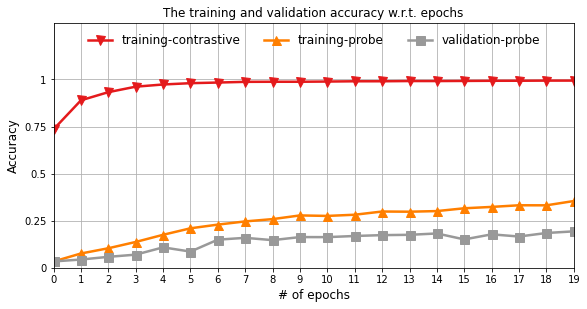

In [24]:
plot_train_results(
                resultfile = "results/contrastive_simple/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["contrastive_accuracy", 
                       "probe_accuracy", "val_probe_accuracy"],
                labels = ["training-contrastive", 
                         "training-probe", "validation-probe"],
                savename = "fig_contrastive_simple_accuracy.pdf",
                legend_location = "upper center",
                normalise = False
            )

saved to:  figures/fig_contrastive_simple_accuracy_top5.pdf


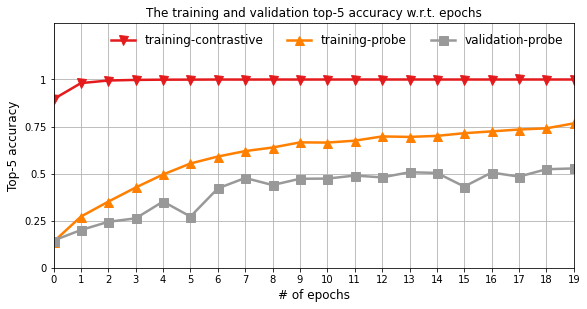

In [25]:
plot_train_results(
                resultfile = "results/contrastive_simple/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["contrastive_accuracy_top-5", 
                       "probe_accuracy_top-5", "val_probe_accuracy_top-5"],
                labels = ["training-contrastive", 
                         "training-probe", "validation-probe"],
                savename = "fig_contrastive_simple_accuracy_top5.pdf",
                legend_location = "best",
                normalise = False
            )

# Contrastive learning with VGG16 without fine-tuning

In [339]:
contrastive_vgg16_encoder = build_vgg16_encoder(image_shape)
contrastive_vgg16_encoder.trainable = False

contrastive_vgg16_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_vgg16_model = ContrastiveModel(   
                                temperature = temperature,
    
                                encoder = contrastive_vgg16_encoder,
    
                                projhead_hidden_dims = (512, 512,),
                                projhead_hidden_activation = "swish",
                                projhead_output_dim = 512,
    
                                image_augmenter = contrastive_vgg16_imgaug,
                                n_classes = n_classes
                            )

contrastive_vgg16_model.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )


## Training

In [340]:
train_evaulate_and_save_models(
                   model = contrastive_vgg16_model,
                   encoder = contrastive_vgg16_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "contrastive_vgg16",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 1194s 5s/step - contrastive_loss: 1.7681 - contrastive_accuracy: 0.8889 - contrastive_accuracy_top-5: 0.9875 - probe_loss: 3.3692 - probe_accuracy: 0.4048 - probe_accuracy_top-5: 0.7501 - val_contrastive_accuracy_top-5: 0.9950 - val_probe_loss: 2.3002 - val_probe_accuracy: 0.4545 - val_probe_accuracy_top-5: 0.8314
Epoch 2/20
241/241 [==============================] - 1204s 5s/step - contrastive_loss: 1.5591 - contrastive_accuracy: 0.9196 - contrastive_accuracy_top-5: 0.9958 - probe_loss: 1.5817 - probe_accuracy: 0.6359 - probe_accuracy_top-5: 0.9307 - val_contrastive_accuracy_top-5: 0.9951 - val_probe_loss: 1.6658 - val_probe_accuracy: 0.5336 - val_probe_accuracy_top-5: 0.8696
Epoch 3/20
241/241 [==============================] - 1199s 5s/step - contrastive_loss: 1.4746 - contrastive_accuracy: 0.9192 - contrastive_accuracy_top-5: 0.9962 - probe_loss: 1.1043 - probe_accuracy: 0.6843 - probe_accuracy_top-5: 0.9516 - val

INFO:tensorflow:Assets written to: models/contrastive_vgg16/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_vgg16/encoder.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_vgg16/main.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_vgg16/main.saved_model/assets



Saving training history data ...


Results:

Maximal contrastive_accuracy: 0.92782
Maximal contrastive_accuracy_top-5: 0.99838
Maximal probe_accuracy: 0.77701
Maximal probe_accuracy_top-5: 0.98029
Maximal val_contrastive_accuracy_top-5: 0.99792
Maximal val_probe_accuracy: 0.58234
Maximal val_probe_accuracy_top-5: 0.89429

-- Completed --



## Plotting results

saved to:  figures/fig_contrastive_vgg16_accuracy.pdf


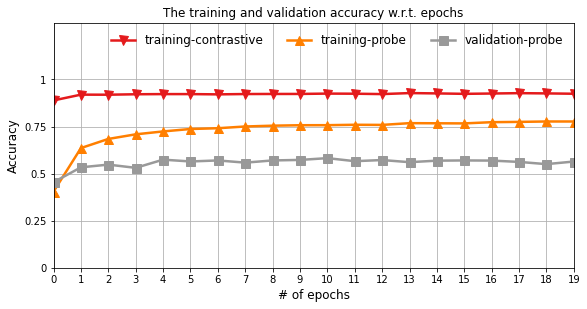

In [26]:
plot_train_results(
                resultfile = "results/contrastive_vgg16/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["contrastive_accuracy", 
                       "probe_accuracy", "val_probe_accuracy"],
                labels = ["training-contrastive", 
                         "training-probe", "validation-probe"],
                savename = "fig_contrastive_vgg16_accuracy.pdf",
                legend_location = "best",
                normalise = False
            )

saved to:  figures/fig_contrastive_vgg16_accuracy_top5.pdf


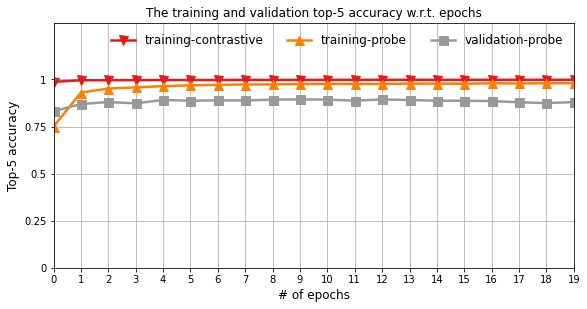

In [27]:
plot_train_results(
                resultfile = "results/contrastive_vgg16/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["contrastive_accuracy_top-5", 
                       "probe_accuracy_top-5", "val_probe_accuracy_top-5"],
                labels = ["training-contrastive", 
                         "training-probe", "validation-probe"],
                savename = "fig_contrastive_vgg16_accuracy_top5.pdf",
                legend_location = "best",
                normalise = False
            )

# Contrastive learning with vision transformer (ViT) encoder

## Vision transformer (ViT) encoder

In [ ]:
# ref: https://keras.io/examples/vision/image_classification_with_vision_transformer/
import tensorflow_addons as tfa

patch_size = 6
n_patches = (image_size[0] // patch_size) ** 2

patch_projection_dim = 64

#attention heads
n_heads = 4

## Creating patches

In [ ]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

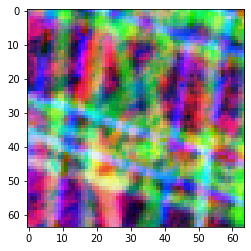

In [263]:
x_batch = next(iter(train_dataset))[0]
x_batch = x_batch.numpy()
x_batch.shape

plt.imshow(x_batch[0])
plt.show()

Image size: (64, 64)
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


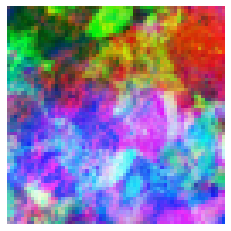

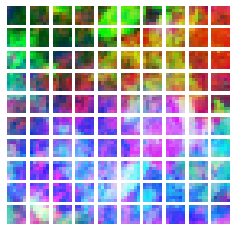

In [251]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

x_batch = next(iter(train_dataset))[0]
x_batch = x_batch.numpy()

image = x_batch[np.random.choice(range(x_batch.shape[0]))]
#plt.imshow(image.astype("uint8"))
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=image_size
    )

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    #plt.imshow(patch_img.numpy().astype("uint8"))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## Patch encoder

In [ ]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, n_patches, patch_projection_dim):
        super(PatchEncoder, self).__init__()
        self.n_patches = n_patches
        
        self.projection = keras.layers.Dense(units = patch_projection_dim)
        
        self.position_embedding = keras.layers.Embedding(
            input_dim = n_patches, output_dim=patch_projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.n_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## ViT MLP

In [ ]:
def vit_mlp(x):
    
    #x = keras.layers.Dense(patch_projection_dim, activation=tf.nn.gelu)(x)
    #x = keras.layers.Dense(patch_projection_dim, activation=tf.nn.gelu)(x)
    
    x = keras.layers.Dense(patch_projection_dim, activation="swish")(x)
    x = keras.layers.Dense(patch_projection_dim, activation="swish")(x)
    
    x = keras.layers.Dropout(0.1)(x)
    
    
    return x

## ViT encoder

In [ ]:
def build_vit_encoder(#*, 
                      image_shape, 
                      #patch_size,
                      #n_patches,
                      #projection_dim
                     ):
    
    inputs = keras.layers.Input(shape=image_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(n_patches, patch_projection_dim)(patches)
    
    
    for _ in range(3):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads = n_heads, key_dim = patch_projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        #x3 = vit_mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        x3 = vit_mlp(x3)
        
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])
    
    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    
    model = keras.Model(inputs=inputs, outputs=representation)
    
    return model

## Building model

In [341]:
contrastive_vit_encoder = build_vit_encoder(image_shape)
contrastive_vit_encoder.trainable = True

contrastive_vit_imgaug = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_vit_model = ContrastiveModel(   
                                temperature = temperature,
    
                                encoder = contrastive_vit_encoder,
    
                                projhead_hidden_dims = (512, 512,),
                                projhead_hidden_activation = "swish",
                                projhead_output_dim = 512,
    
                                image_augmenter = contrastive_vit_imgaug,
                                n_classes = n_classes
                            )

contrastive_vit_model.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )


## Training

In [342]:
train_evaulate_and_save_models(
                   model = contrastive_vit_model,
                   encoder = contrastive_vit_encoder,
                   train_dataset = train_dataset,
                   test_dataset = test_dataset,
                   epochs = n_epochs,
                   savename = "contrastive_vit",
                  )


Training ...

Epoch 1/20
241/241 [==============================] - 425s 2s/step - contrastive_loss: 2.2592 - contrastive_accuracy: 0.6784 - contrastive_accuracy_top-5: 0.8165 - probe_loss: 6.0214 - probe_accuracy: 0.0683 - probe_accuracy_top-5: 0.2238 - val_contrastive_accuracy_top-5: 0.9962 - val_probe_loss: 4.3649 - val_probe_accuracy: 0.1217 - val_probe_accuracy_top-5: 0.3758
Epoch 2/20
241/241 [==============================] - 447s 2s/step - contrastive_loss: 1.2982 - contrastive_accuracy: 0.9596 - contrastive_accuracy_top-5: 0.9981 - probe_loss: 3.2758 - probe_accuracy: 0.2435 - probe_accuracy_top-5: 0.6194 - val_contrastive_accuracy_top-5: 0.9975 - val_probe_loss: 4.4618 - val_probe_accuracy: 0.1648 - val_probe_accuracy_top-5: 0.4796
Epoch 3/20
241/241 [==============================] - 459s 2s/step - contrastive_loss: 1.2178 - contrastive_accuracy: 0.9711 - contrastive_accuracy_top-5: 0.9990 - probe_loss: 2.9967 - probe_accuracy: 0.3239 - probe_accuracy_top-5: 0.7285 - val_co

INFO:tensorflow:Assets written to: models/contrastive_vit/encoder.saved_model/assets


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
INFO:tensorflow:Assets written to: models/contrastive_vit/encoder.saved_model/assets
/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/contrastive_vit/main.saved_model/assets


INFO:tensorflow:Assets written to: models/contrastive_vit/main.saved_model/assets



Saving training history data ...


Results:

Maximal contrastive_accuracy: 0.99360
Maximal contrastive_accuracy_top-5: 1.00000
Maximal probe_accuracy: 0.73614
Maximal probe_accuracy_top-5: 0.97208
Maximal val_contrastive_accuracy_top-5: 0.99994
Maximal val_probe_accuracy: 0.50935
Maximal val_probe_accuracy_top-5: 0.81974

-- Completed --



## Plotting results

saved to:  figures/fig_contrastive_vit_accuracy.pdf


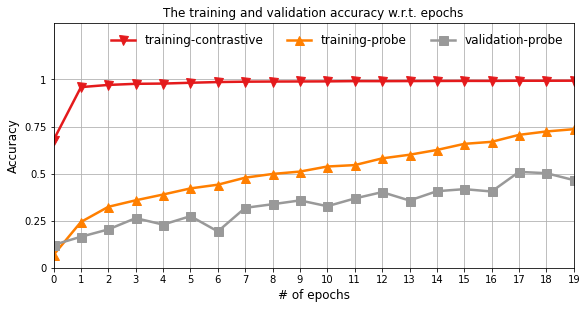

In [28]:
plot_train_results(
                resultfile = "results/contrastive_vit/history_train.pickle", 
                title = "The training and validation accuracy w.r.t. epochs",
                ylabel = "Accuracy",
                keys = ["contrastive_accuracy", 
                       "probe_accuracy", "val_probe_accuracy"],
                labels = ["training-contrastive", 
                         "training-probe", "validation-probe"],
                savename = "fig_contrastive_vit_accuracy.pdf",
                legend_location = "best",
                normalise = False
            )

saved to:  figures/fig_contrastive_vit_accuracy_top5.pdf


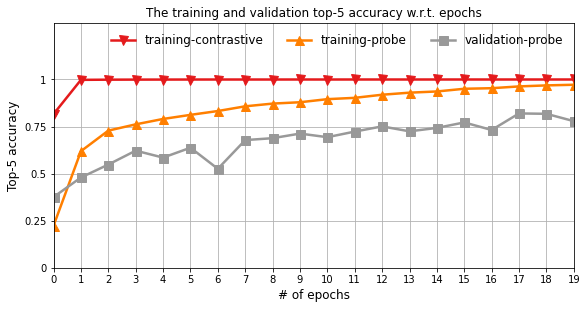

In [29]:
plot_train_results(
                resultfile = "results/contrastive_vit/history_train.pickle", 
                title = "The training and validation top-5 accuracy w.r.t. epochs",
                ylabel = "Top-5 accuracy",
                keys = ["contrastive_accuracy_top-5", 
                       "probe_accuracy_top-5", "val_probe_accuracy_top-5"],
                labels = ["training-contrastive", 
                         "training-probe", "validation-probe"],
                savename = "fig_contrastive_vit_accuracy_top5.pdf",
                legend_location = "best",
                normalise = False
            )

# The facilities of plotting comparisons

In [482]:
import pickle

import matplotlib.pyplot as plt
from matplotlib import cm

from itertools import cycle

def plot_comparing_results(
                                resultfiles, #a list of files
                                keys,
                                labels,
    
                                title,
                                ylabel,
                                
                                legend_location = "best",
    
                                savename = None,
                                normalise_data = False
                            ):
    
    
    
    
    fig_width = 12.
    fig_height = fig_width*0.5

    fig = plt.figure(figsize=(fig_width, fig_height))

    
    plt.subplots_adjust(left = 0.05, 
                        right = 0.95, 
                        bottom = 0.1, 
                        top = 0.95)
    
    

    n = len(keys)
    
    colours = iter(cm.tab10(np.linspace(0, 1, n)))
    
    linestyles = cycle(["-", "--", "-.", ":"])
    
    markers = cycle(["v", "^", "s", "<", ">", "D"])
    
    for f, k, label in zip(resultfiles, keys, labels):
        
        print(f"loading {f} with key: {k} and label: {label} ...")
        
        if not os.path.exists(f):
            continue
    
        history = pickle.load(open(f, "rb"))
        
        if k not in history:
            print(f"key {k} not found")
            continue
        
        v = history[k]
        
        if normalise_data:
            v = np.array(v) / max(v)
        
        c = next(colours)
        ls = next(linestyles)
        m = next(markers)
        
        plt.plot(
                    v, 
                    color = c, 
                    label = label, 
                    linewidth = 2.5, 
                    linestyle = ls,
                    marker = m,
                    markersize = 9
                )
    
    plt.xlabel("# of epochs", fontsize = 12)
    
    plt.ylabel(ylabel, fontsize = 12)
    
    #k = keys[0]
    #v = history[k]
    plt.xlim(0, len(v) - 1)
    plt.ylim(0, 1.2)

    xticks = np.linspace(0, 
                     len(v) - 1, 
                     num = len(v), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)
    plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

    plt.grid()
    
    plt.legend(
            loc = legend_location, #'upper center',
            fontsize = 12,
            ncol = 4, 
            frameon = False)
    
    if not os.path.exists("figures"):
        os.makedirs("figures")
        
    if savename:
        figpath = "figures" + os.path.sep + savename
        plt.savefig(figpath, 
                    dpi=600, 
                    format='pdf')
        
        print("saved to: ", figpath)
    
    plt.title(title)

    plt.show()

# Comparing training probe accuracy

loading results/baseline_simple/history_train.pickle with key: accuracy and label: baseline-simple ...
loading results/baseline_vgg16/history_train.pickle with key: accuracy and label: baseline-vgg16 ...
loading results/baseline_resnet/history_train.pickle with key: accuracy and label: baseline-resnet50 ...
loading results/baseline_mobilenet/history_train.pickle with key: accuracy and label: baseline-mobilenet ...
loading results/contrastive_simple/history_train.pickle with key: probe_accuracy and label: contrastive-simple ...
loading results/contrastive_vgg16/history_train.pickle with key: probe_accuracy and label: contrastive-vgg16 ...
loading results/contrastive_vit/history_train.pickle with key: probe_accuracy and label: contrastive-vit ...
saved to:  figures/fig_training_accuracy_comparison.pdf


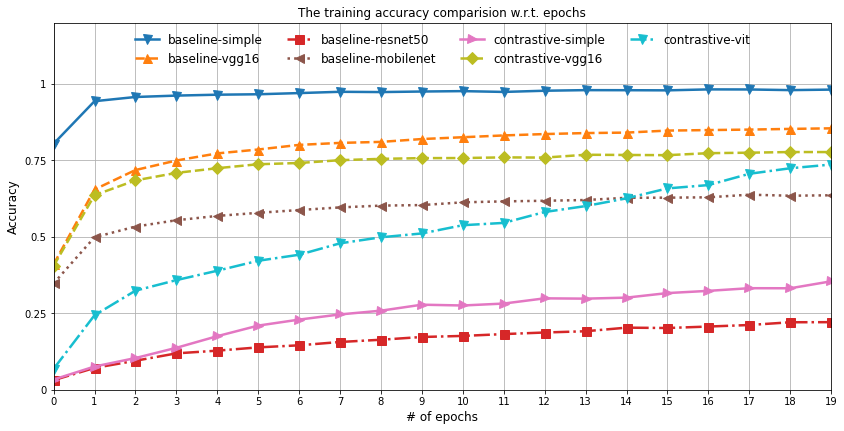

In [483]:
keys = [
        "accuracy",
        "accuracy",
        "accuracy",
        "accuracy",
        
        "probe_accuracy",
        "probe_accuracy",
        "probe_accuracy",
    ]

resultfiles = [
        "results/baseline_simple/history_train.pickle",
        "results/baseline_vgg16/history_train.pickle",
        "results/baseline_resnet/history_train.pickle",
        "results/baseline_mobilenet/history_train.pickle",
    
        "results/contrastive_simple/history_train.pickle",
        "results/contrastive_vgg16/history_train.pickle",
        "results/contrastive_vit/history_train.pickle",
    ]

labels = [
        "baseline-simple",
        "baseline-vgg16",
        "baseline-resnet50",
        "baseline-mobilenet",
    
        "contrastive-simple",
        "contrastive-vgg16",
        "contrastive-vit",
    ]

plot_comparing_results(
                                resultfiles = resultfiles,
                                keys = keys,
                                labels = labels,
    
                                title = "The training accuracy comparision w.r.t. epochs",
                                ylabel = "Accuracy",
                                
                                legend_location = "upper center",
    
                                savename = "fig_training_accuracy_comparison.pdf",
    
                                normalise_data = False
                            )

# Comparing validation accuracy

loading results/baseline_simple/history_train.pickle with key: val_accuracy and label: baseline-simple ...
loading results/baseline_vgg16/history_train.pickle with key: val_accuracy and label: baseline-vgg16 ...
loading results/baseline_resnet/history_train.pickle with key: val_accuracy and label: baseline-resnet50 ...
loading results/baseline_mobilenet/history_train.pickle with key: val_accuracy and label: baseline-mobilenet ...
loading results/contrastive_simple/history_train.pickle with key: val_probe_accuracy and label: contrastive-simple ...
loading results/contrastive_vgg16/history_train.pickle with key: val_probe_accuracy and label: contrastive-vgg16 ...
loading results/contrastive_vit/history_train.pickle with key: val_probe_accuracy and label: contrastive-vit ...
saved to:  figures/fig_validation_accuracy_comparison.pdf


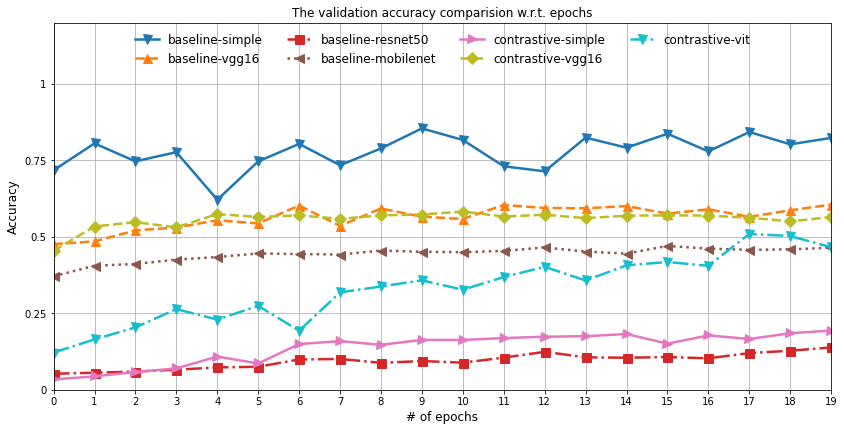

In [484]:
keys = [
        "val_accuracy",
        "val_accuracy",
        "val_accuracy",
        "val_accuracy",
        
        "val_probe_accuracy",
        "val_probe_accuracy",
        "val_probe_accuracy",
    ]

resultfiles = [
        "results/baseline_simple/history_train.pickle",
        "results/baseline_vgg16/history_train.pickle",
        "results/baseline_resnet/history_train.pickle",
        "results/baseline_mobilenet/history_train.pickle",
    
        "results/contrastive_simple/history_train.pickle",
        "results/contrastive_vgg16/history_train.pickle",
        "results/contrastive_vit/history_train.pickle",
    ]

labels = [
        "baseline-simple",
        "baseline-vgg16",
        "baseline-resnet50",
        "baseline-mobilenet",
    
        "contrastive-simple",
        "contrastive-vgg16",
        "contrastive-vit",
    ]

plot_comparing_results(
                                resultfiles = resultfiles,
                                keys = keys,
                                labels = labels,
    
                                title = "The validation accuracy comparision w.r.t. epochs",
                                ylabel = "Accuracy",
                                
                                legend_location = "upper center",
    
                                savename = "fig_validation_accuracy_comparison.pdf",
    
                                normalise_data = False
                            )

# Comparing top-5 training accuracy

loading results/baseline_simple/history_train.pickle with key: accuracy_top-5 and label: baseline-simple ...
loading results/baseline_vgg16/history_train.pickle with key: accuracy_top-5 and label: baseline-vgg16 ...
loading results/baseline_resnet/history_train.pickle with key: accuracy_top-5 and label: baseline-resnet50 ...
loading results/baseline_mobilenet/history_train.pickle with key: accuracy_top-5 and label: baseline-mobilenet ...
loading results/contrastive_simple/history_train.pickle with key: probe_accuracy_top-5 and label: contrastive-simple ...
loading results/contrastive_vgg16/history_train.pickle with key: probe_accuracy_top-5 and label: contrastive-vgg16 ...
loading results/contrastive_vit/history_train.pickle with key: probe_accuracy_top-5 and label: contrastive-vit ...
saved to:  figures/fig_training_accuracy_comparison_top5.pdf


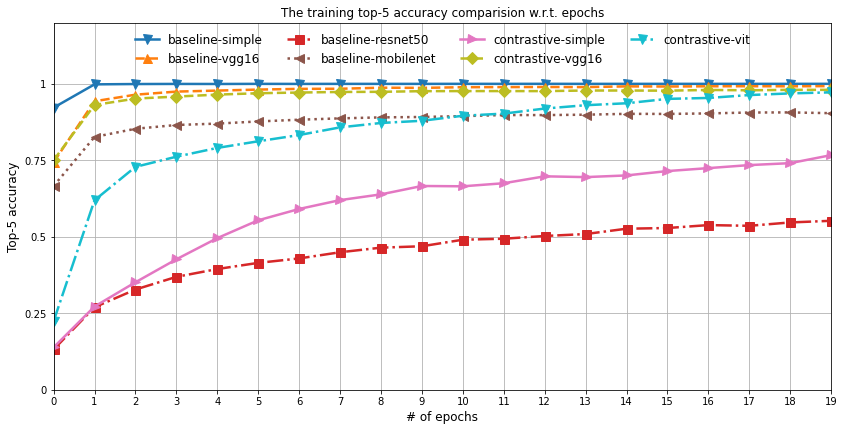

In [485]:
keys = [
        "accuracy_top-5",
        "accuracy_top-5",
        "accuracy_top-5",
        "accuracy_top-5",
        
        "probe_accuracy_top-5",
        "probe_accuracy_top-5",
        "probe_accuracy_top-5",
    ]

resultfiles = [
        "results/baseline_simple/history_train.pickle",
        "results/baseline_vgg16/history_train.pickle",
        "results/baseline_resnet/history_train.pickle",
        "results/baseline_mobilenet/history_train.pickle",
    
        "results/contrastive_simple/history_train.pickle",
        "results/contrastive_vgg16/history_train.pickle",
        "results/contrastive_vit/history_train.pickle",
    ]

labels = [
        "baseline-simple",
        "baseline-vgg16",
        "baseline-resnet50",
        "baseline-mobilenet",
    
        "contrastive-simple",
        "contrastive-vgg16",
        "contrastive-vit",
    ]

plot_comparing_results(
                                resultfiles = resultfiles,
                                keys = keys,
                                labels = labels,
    
                                title = "The training top-5 accuracy comparision w.r.t. epochs",
                                ylabel = "Top-5 accuracy",
                                
                                legend_location = "upper center",
    
                                savename = "fig_training_accuracy_comparison_top5.pdf",
    
                                normalise_data = False
                            )

# Comparing top-5 validation accuracy

loading results/baseline_simple/history_train.pickle with key: val_accuracy_top-5 and label: baseline-simple ...
loading results/baseline_vgg16/history_train.pickle with key: val_accuracy_top-5 and label: baseline-vgg16 ...
loading results/baseline_resnet/history_train.pickle with key: val_accuracy_top-5 and label: baseline-resnet50 ...
loading results/baseline_mobilenet/history_train.pickle with key: val_accuracy_top-5 and label: baseline-mobilenet ...
loading results/contrastive_simple/history_train.pickle with key: val_probe_accuracy_top-5 and label: contrastive-simple ...
loading results/contrastive_vgg16/history_train.pickle with key: val_probe_accuracy_top-5 and label: contrastive-vgg16 ...
loading results/contrastive_vit/history_train.pickle with key: val_probe_accuracy_top-5 and label: contrastive-vit ...
saved to:  figures/fig_validation_accuracy_comparison_top5.pdf


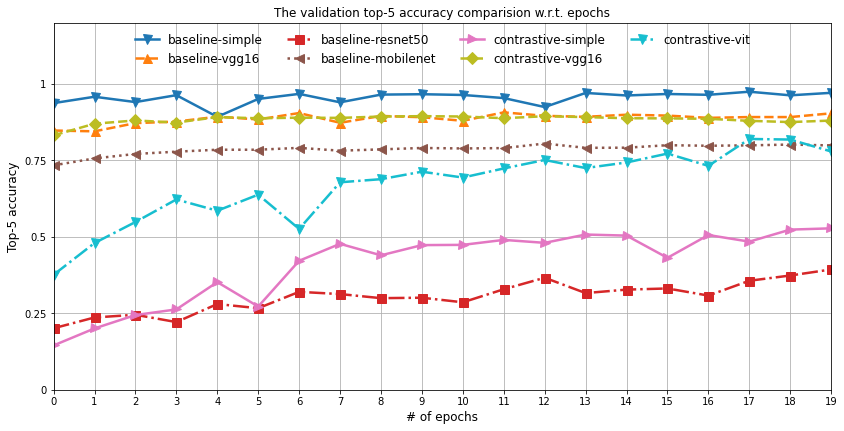

In [486]:
keys = [
        "val_accuracy_top-5",
        "val_accuracy_top-5",
        "val_accuracy_top-5",
        "val_accuracy_top-5",
        
        "val_probe_accuracy_top-5",
        "val_probe_accuracy_top-5",
        "val_probe_accuracy_top-5",
    ]

resultfiles = [
        "results/baseline_simple/history_train.pickle",
        "results/baseline_vgg16/history_train.pickle",
        "results/baseline_resnet/history_train.pickle",
        "results/baseline_mobilenet/history_train.pickle",
    
        "results/contrastive_simple/history_train.pickle",
        "results/contrastive_vgg16/history_train.pickle",
        "results/contrastive_vit/history_train.pickle",
    ]

labels = [
        "baseline-simple",
        "baseline-vgg16",
        "baseline-resnet50",
        "baseline-mobilenet",
    
        "contrastive-simple",
        "contrastive-vgg16",
        "contrastive-vit",
    ]

plot_comparing_results(
                                resultfiles = resultfiles,
                                keys = keys,
                                labels = labels,
    
                                title = "The validation top-5 accuracy comparision w.r.t. epochs",
                                ylabel = "Top-5 accuracy",
                                
                                legend_location = "upper center",
    
                                savename = "fig_validation_accuracy_comparison_top5.pdf",
    
                                normalise_data = False
                            )

# The facilities of plotting 2D projections

## Plotting one model

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

import os
import sys 

import random

from sklearn.manifold import TSNE
#from sklearn.metrics import pairwise_distances
import umap

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

def plot_projection_one(
                    features,
                    labels,
                         
                    title,
                     
                    legend_location = "best",
    
                    savename = None,
    
                    #kernelpca-cosine, tsne-cosine, umap-cosine
                    algo = "kernelpca-cosine",     
                ):
      
    
    fig_width = 7
    fig_height = 7

    fig = plt.figure(figsize=(fig_width, fig_height))

    
    plt.subplots_adjust(left = 0.05, 
                        right = 0.95, 
                        bottom = 0.05, 
                        top = 0.95)
    
    #building colours
    colours_dict = {}
    colours_ = iter(cm.rainbow(np.linspace(0, 1, len(set(labels)))))
    
    for label in set(labels):
        colours_dict[label] = next(colours_)
 
    
    #n_classes = len(set(labels))

    #class_labels = list(set(labels))
    
    
    reducers_dict = {
        "kernelpca-cosine": KernelPCA(n_components=2, 
                                      kernel = "cosine"),
        
        "tsne-cosine": TSNE( metric = "cosine",
                             square_distances = True,
                             n_iter = 15000,  
                             n_jobs = -1, 
                             random_state = 1133),
        
        "umap-cosine": umap.UMAP(metric = "cosine")
    }
    
       
    reducer = reducers_dict[algo]
    
    projections = reducer.fit_transform(features)
        
    
    for idx, (xi, label) in enumerate(zip(projections, labels)):
        plt.scatter(xi[0], 
                    xi[1],
                    s = 70,
                    alpha = 0.5,
                    edgecolors = None,
                    linewidths = 0,
                    color = colours_dict[label],
                    label = f"class-{label}")
        
    if not os.path.exists("figures"):
        os.makedirs("figures")
        
    if savename:
        figpath = "figures" + os.path.sep + savename
        
        plt.savefig(figpath, 
                    dpi = 600, 
                    format = 'pdf')
        
        print("saved to: ", figpath)
        
        
    plt.show()
     
    
    plt.close()


## Plotting model comparison

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

import os
import sys 

import random

from sklearn.manifold import TSNE
#from sklearn.metrics import pairwise_distances
import umap

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA


import math


def plot_projections(
                    features_dict,
                    labels,
    
                    keys, 
    
                    title,
                    subtitles,
    
                    ncols = 2,
        
                    savename = None,
    
                    #kernelpca-cosine, tsne-cosine, umap-cosine
                    algo = "kernelpca-cosine",    
    
                    subfig_height = 4,
                    subfig_width = 4,
                ):
      
    
    nrows = math.ceil(len(keys) / ncols)
    
    print(f"nrows = {nrows} ncols = {ncols}")
    
    fig_width = ncols * subfig_width
    fig_height = nrows * subfig_height

    #fig = plt.figure(figsize=(fig_width, fig_height))
    figsize=(fig_width, fig_height)
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    
    axes_flat = axes.flat
    
    plt.subplots_adjust(left = 0.05, 
                        right = 0.95, 
                        bottom = 0.05, 
                        top = 0.95)
    
    #building colours
    colours_dict = {}
    colours_ = iter(cm.rainbow(np.linspace(0, 1, len(set(labels)))))
    
    
    for label in set(labels):
        colours_dict[label] = next(colours_)
 
    
    #n_classes = len(set(labels_))
    #class_labels = list(set(labels))
    
    
    reducers_dict = {
        "kernelpca-cosine": KernelPCA(n_components=2, 
                                      kernel = "cosine"),
        
        "tsne-cosine": TSNE( metric = "cosine",
                             square_distances = True,
                             n_iter = 15000,  
                             n_jobs = -1, 
                             random_state = 1133),
        
        "umap-cosine": umap.UMAP(metric = "cosine")
    }
    
       
    reducer = reducers_dict[algo]
    
    projections_dict = {}
    
    for key in keys:
        features = features_dict[key]
        projections = reducer.fit_transform(features)
        projections_dict[key] = projections
    
    
    for row in range(nrows):
        for col in range(ncols): 
            
            key_idx = row * ncols + col
            
            if key_idx >= len(keys):
                continue
            
            key = keys[key_idx]
            
            projections = projections_dict[key]
            
            ax = axes_flat[key_idx]
            
            subtitle = subtitles[key_idx]
            
            ax.title.set_text(subtitle)
            
            for idx, (xi, label) in enumerate(zip(projections, labels)):
                label = labels[idx]
                ax.scatter( 
                            xi[0], 
                            xi[1],
                            s = 70,
                            alpha = 0.5,
                            edgecolors = None,
                            linewidths = 0,
                            color = colours_dict[label],
                            label = f"class-{label}"
                        )
                
        
    if not os.path.exists("figures"):
        os.makedirs("figures")
        
    if savename:
        figpath = "figures" + os.path.sep + savename
        
        plt.savefig(figpath, 
                    dpi = 600, 
                    format = 'pdf')
        
        print("saved to: ", figpath)
        
        
    plt.show()
     
    
    plt.close()


# Sampling images for projection visualisation

In [11]:
def sample_projection_images(
                        dataset, 
                        n_classes = 6, 
                        n_images_per_class = 20,
                    ):
    
    # convert tensorflow dataset to numpy
    X = []
    y = []

    for xi, yi in dataset.as_numpy_iterator():
        X = X + list(xi)
        y = y + list(yi)
    
    X = np.array(X, dtype = object)
    y = np.array(y, dtype = object)

    
    print("X.shape = ", X.shape)
    print("y.shape = ", y.shape)
    
    
    # randomly choose classes
    chosen_classes = np.random.choice(list(set(y)), 
                                      size = n_classes, 
                                      replace = False)
    print("chosen_classes = ", chosen_classes)


    images = []
    labels = []

    for label in chosen_classes:
    
        indices = np.where(y == label)
        indices = indices[0]
        
        if len(indices) < n_images_per_class:
            size = len(indices)
        else:
            size = n_images_per_class
            
        #print(size)
        
        chosen_indices = np.random.choice(list(indices), 
                                     size = size, 
                                     replace = False)
    
        images = images + list(X[chosen_indices])
        labels = labels + list(y[chosen_indices])

    images = np.array(images, dtype = object)
    labels = np.array(labels, dtype = object)

    print("images.shape = ", images.shape)
    print("labels.shape = ", labels.shape)
        
    return images, labels

In [71]:
import pickle
import os

if not os.path.exists("data"):
    os.makedirs("data")
    
images, labels = sample_projection_images(
                        dataset = test_dataset, 
                        n_classes = 6, 
                        n_images_per_class = 40
                    )

data = {}
data["images"] = images
data["labels"] = labels

pickle.dump(data, open("data" + os.path.sep + "projection_samples.pickle", "wb" ))

del data, images, labels

X.shape =  (7700, 64, 64, 3)
y.shape =  (7700,)
chosen_classes =  [45 99 10 28 80 16]
images.shape =  (240, 64, 64, 3)
labels.shape =  (240,)


In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

import numpy as np
import pandas as pd
import os
import sys
import random

import matplotlib.pyplot as plt

import pickle
import os

data = pickle.load(open("data" + os.path.sep + "projection_samples.pickle", "rb"))

images = data["images"]
labels = data["labels"]

del data

# Projection algorithm setting

In [12]:
project_algo = "kernelpca-cosine"

# Projecting raw images

features.shape =  (240, 12288)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_raw.pdf


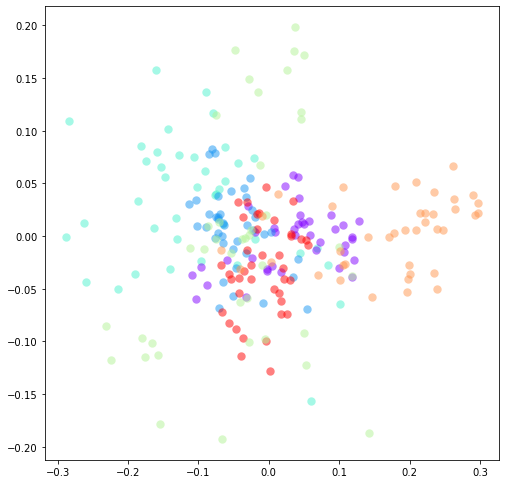

In [8]:
n_feature_dims = np.prod(images[0].shape)

features = images.reshape(-1, n_feature_dims)
print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of raw images",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_raw.pdf",
    
                    algo = project_algo
                )

# Projecting with baseline simple model

features.shape =  (240, 154)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_baseline_simple.pdf


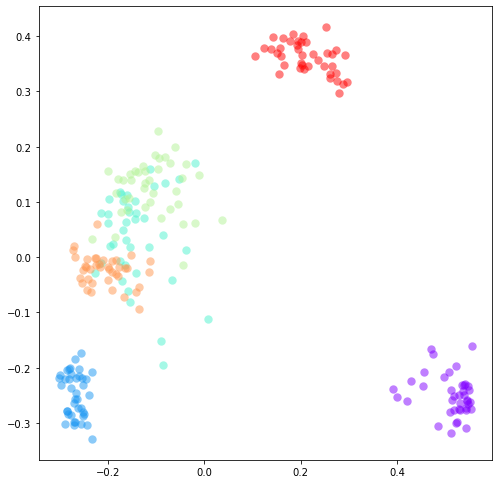

In [9]:
model = keras.models.load_model("models/baseline_simple/main.saved_model")

images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of baseline simple model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_baseline_simple.pdf",
    
                    algo = project_algo
                )

del model

# Projecting with baseline VGG16

features.shape =  (240, 154)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_baseline_vgg16.pdf


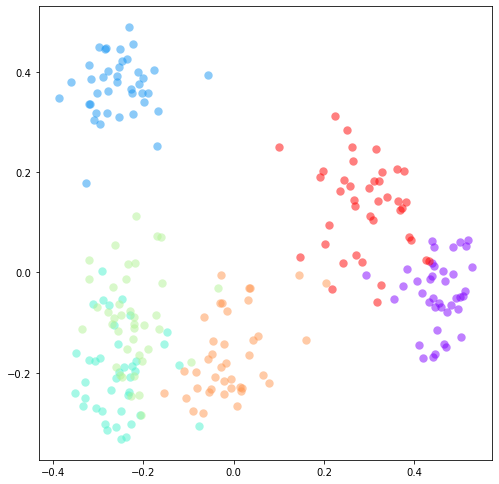

In [10]:
model = keras.models.load_model("models/baseline_vgg16/main.saved_model")

images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of baseline VGG16 model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_baseline_vgg16.pdf",
    
                    algo = project_algo
                )

del model

# Projecting with baseline ResNet50

features.shape =  (240, 154)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_baseline_resnet.pdf


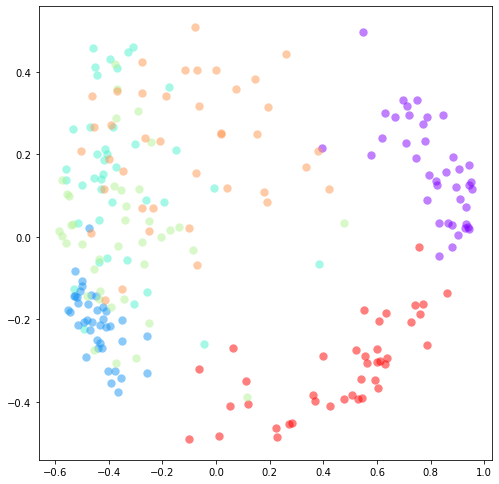

In [11]:
model = keras.models.load_model("models/baseline_resnet/main.saved_model")


images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of baseline ResNet50 model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_baseline_resnet.pdf",
    
                    algo = project_algo
                )

del model

# Projecting with baseline MobileNet

features.shape =  (240, 154)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_baseline_mobilenet.pdf


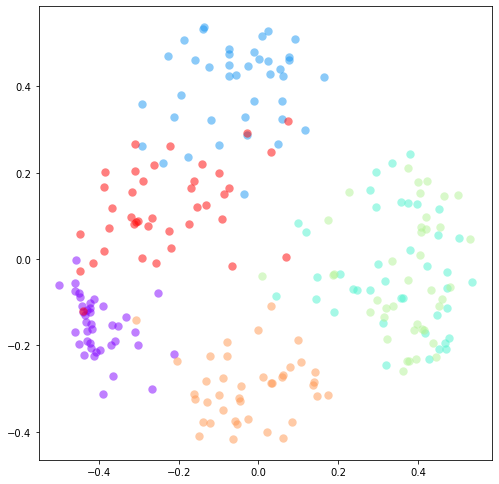

In [13]:
model = keras.models.load_model("models/baseline_mobilenet/main.saved_model")


images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of baseline MobileNet model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_baseline_mobilenet.pdf",
    
                    algo = project_algo
                )

del model

# Projecting with contrastive simple model

features.shape =  (240, 512)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_contrastive_simple.pdf


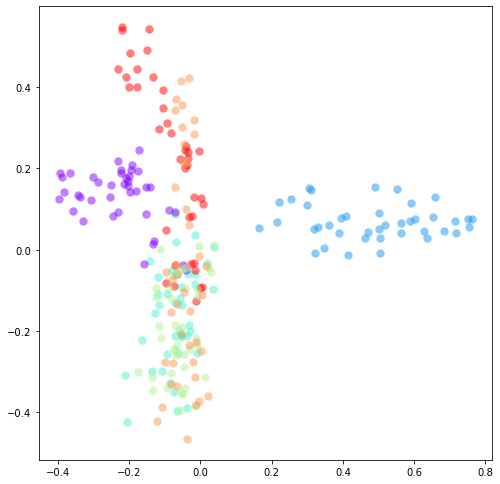

In [14]:
model = keras.models.load_model("models/contrastive_simple/main.saved_model")


images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of contrastive simple model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_contrastive_simple.pdf",
    
                    algo = project_algo
                )

del model

# Projecting with contrastive VGG16

features.shape =  (240, 512)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_contrastive_vgg16.pdf


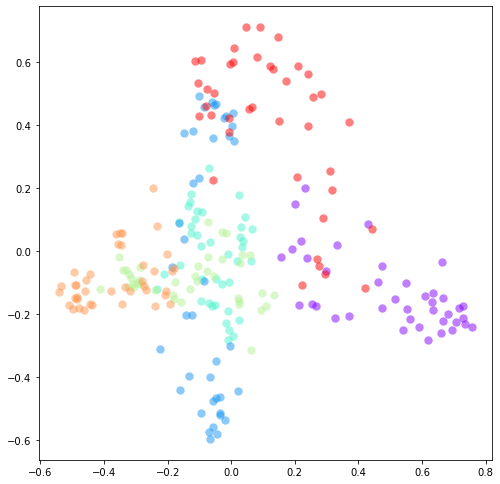

In [15]:
model = keras.models.load_model("models/contrastive_vgg16/main.saved_model")


images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of contrastive VGG16 model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_contrastive_vgg16.pdf",
    
                    algo = project_algo
                )

del model

# Projecting with contrastive ViT

features.shape =  (240, 512)
projections.shape =  (240, 2)
saved to:  figures/fig_2d_proj_contrastive_vit.pdf


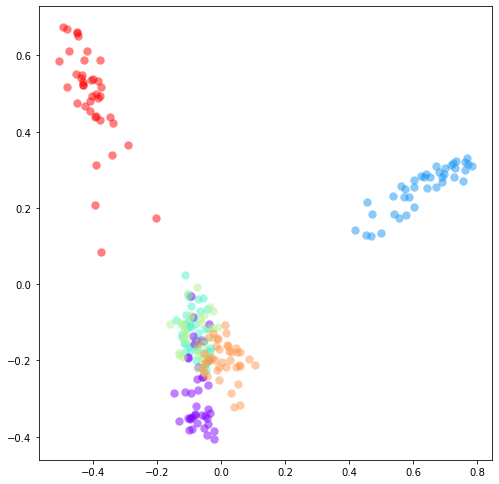

In [16]:
model = keras.models.load_model("models/contrastive_vit/main.saved_model")


images_ = images.astype("float32")
images_ = tf.convert_to_tensor(images_)

features_ = model(images_)
features = features_.numpy()

print("features.shape = ", features.shape)

plot_projection_one(
                    features = features,
                    labels = labels,
                         
                    title = "The 2D projection of contrastive ViT model",
                     
                    legend_location = "best",
    
                    savename = "fig_2d_proj_contrastive_vit.pdf",
    
                    algo = project_algo
                )

del model

# Projecting model comparison

In [7]:
def images_to_features(images, model_path):
    model = keras.models.load_model(model_path)


    images_ = images.copy().astype("float32")
    images_ = tf.convert_to_tensor(images_)

    features_ = model(images_)
    features = features_.numpy()

    return features


keys = [
        "raw-image",
        "baseline-simple", 
        "baseline-vgg16",
        "baseline-resnet",
        "baseline-mobilenet",
        "contrastive-simple",
        "contrastive-vgg16",
        "contrastive-vit"
       ]

subtitles = keys

mode_paths_dict = {
    "baseline-simple": "models/baseline_simple/main.saved_model",
    "baseline-vgg16": "models/baseline_vgg16/main.saved_model",
    "baseline-resnet": "models/baseline_resnet/main.saved_model",
    "baseline-mobilenet": "models/baseline_mobilenet/main.saved_model",
    
    "contrastive-simple": "models/contrastive_simple/main.saved_model",
    "contrastive-vgg16": "models/contrastive_vgg16/main.saved_model",
    "contrastive-vit": "models/contrastive_vit/main.saved_model",
}

features_dict = {
                    key: images_to_features(images, mode_paths_dict[key]) 
                        for key in keys if key != "raw-image"
                }

n_feature_dims = np.prod(images[0].shape)
features = images.copy().reshape(-1, n_feature_dims)
features_dict["raw-image"] = features

nrows = 2 ncols = 4
saved to:  figures/fig_projection_comparison.pdf


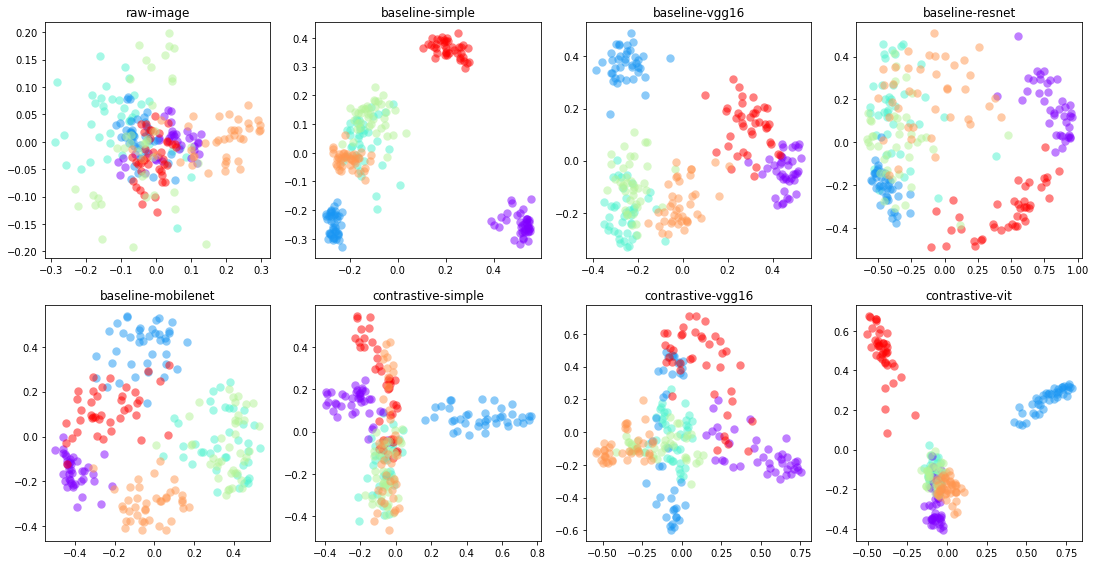

In [13]:
plot_projections(
                    features_dict = features_dict,
                    labels = labels,
    
                    keys = keys, 
    
                    subtitles = subtitles,
                    title = "Feature projection comparison",
                    
                    ncols = 4,
        
                    savename = "fig_projection_comparison.pdf",
    
                    #kernelpca-cosine, tsne-cosine, umap-cosine
                    algo = "kernelpca-cosine",    
    
                    subfig_height = 4,
                    subfig_width = 4,
                )

# Conclusions